<a href="https://colab.research.google.com/github/Doclikam/Causal-inference-for-Treatment-Effects-in-Head-Neck-Radiotherapy./blob/main/Notebooks/Copy_of_Causal_Modelling_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RADCURE - CHEMOTHERAPY/RADIOTHERAPY CANCER RESPONSE**

# **Assumptions of Cuasal Machine Learning**

**Positivity(overlap):**  Every patient must have a non-zero probability of receiving either treatment option, given their baseline confounders.

**Consistency (SUTVA):**
Each patient’s outcome corresponds to the treatment they received, with no interference across patients.

**Conditional Exchangeability:**
Given baseline confounders 𝑋 treatment assignment 𝐴 is independent of potential outcomes:

                                        Y(a)⊥A∣X
**Ignorability**

Ignorability assumes that after adjusting for all measured confounders,
treatment assignment is ‘as good as random.’
This assumption allows us to estimate causal effects from observational data

In [1]:
pip install joblib


In [2]:
pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.50.0
    Uninstalling shap-0.50.0:
      Successfully uninstalled shap-0.50.0


In [3]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=57543f8c574806754db4d415f5a841fb8d5e5d3fcb771a3e35fd780edd88c72b
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
#main libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.ensemble import GradientBoostingClassifier

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import statsmodels.api as sm
from econml.dml import CausalForestDML
from scipy.special import expit

import joblib
import os
os.makedirs("outputs", exist_ok=True)

# Display all columns
pd.set_option('display.max_columns', None)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
rad_analysis = pd.read_csv("/content/rad_data_analysis (6).csv")#load the excel file
rad_analysis.head(5)#visulize the first 5 patients

,patient_id,treatment,time_os_days,event_os,time_pfs_days,event_pfs,time_pfs_days.1,event_pfs.1,age,sex,ecog_ps,ecog_ps_missing,smoking_status_clean,smoking_py_clean,smoking_py_missing,smoking_mismatch_flag,primary_site_group,subsite_clean,subsite_missing,t,n,m,stage,t_missing,n_missing,m_missing,stage_missing,hpv_clean,hpv_missing,hpv_specific_tumors,pathology_group,is_non_tnm,tnm_structural_missing,followup_days,dose,fx,length_fu,d_per_fx,BED,EQD2,BED_eff
0,RADCURE-0005,0,446.0,1,446.0,1,446.0,1,62.6,Female,0.0,0,Ex-Smoker,50.0,0,0,Oropharynx,Post Wall,0,T4b,N2c,M0,IVB,0,0,0,0,HPV_Negative,0,1,SCC,0,0,446.0,60.0,25,1.317808,2.40,74.400,62.000000,74.400
1,RADCURE-0006,0,527.0,1,527.0,1,527.0,1,87.3,Male,2.0,0,Ex-Smoker,25.0,0,0,Larynx,Glottis,0,T1b,N0,M0,I,0,0,0,0,NaN,0,0,SCC,0,0,527.0,51.0,20,1.520548,2.55,64.005,53.337500,64.005
2,RADCURE-0007,0,756.0,0,756.0,0,756.0,0,49.9,Male,1.0,0,Ex-Smoker,15.0,0,0,Oropharynx,Tonsil,0,T3,N2b,M0,IVA,0,0,0,0,HPV_Positive,0,1,SCC,0,0,756.0,64.0,40,2.126027,1.60,74.240,61.866667,74.240
3,RADCURE-0009,0,2059.0,0,2059.0,0,2059.0,0,72.3,Male,1.0,0,Ex-Smoker,30.0,0,0,Other_HNC,NaN,0,T0,N2c,M0,IVA,0,0,0,0,NaN,0,0,SCC,0,0,2059.0,70.0,35,5.791781,2.00,84.000,70.000000,84.000
4,RADCURE-0010,0,3444.0,0,3444.0,0,3444.0,0,59.7,Female,0.0,0,Non-Smoker,0.0,0,0,Oropharynx,Tonsillar Fossa,0,T4b,N0,M0,IVB,0,0,0,0,HPV_Negative,0,1,SCC,0,0,3444.0,64.0,40,9.512329,1.60,74.240,61.866667,74.240


In [ ]:
rad_analysis.columns

Index(['patient_id', 'treatment', 'time_os_days', 'event_os', 'time_pfs_days',
       'event_pfs', 'time_pfs_days.1', 'event_pfs.1', 'age', 'sex', 'ecog_ps',
       'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean',
       'smoking_py_missing', 'smoking_mismatch_flag', 'primary_site_group',
       'subsite_clean', 'subsite_missing', 't', 'n', 'm', 'stage', 't_missing',
       'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing',
       'hpv_specific_tumors', 'pathology_group', 'is_non_tnm',
       'tnm_structural_missing', 'followup_days', 'dose', 'fx', 'length_fu',
       'd_per_fx', 'BED', 'EQD2', 'BED_eff'],
      dtype='object')

# Propensity Scores

**Propensity score (PS) model:**

In  observational studies thre are sytemic diffrences between the treated and untreated groups which may result in bias, propensity scores can help to account for these differnces addressing the bias.

By creating more comparable controlk group, the score provides a method for estimating the causal effects of the treatment (Radiotehrapy vs radiochemotherapy) on the ouitcome (event occurence, time to event)

However, one limitation of propesnity scoring is that it can only balance the groups on the features that are measured and included in the model, hence canmnot account for unmeasured confounders.

PS(x)=P(Treatment=1∣X=x)  


for each patient, what’s the probability they receive ChemoRT given their observed baseline characteristics X

Here:

X is a matrix of confounders (age, sex, ECOG, smoking, TNM, HPV, etc.) that influence treatment assignment.

y is a binary vector: 1 if patient received ChemoRT, 0 if RT alone.

In [ ]:
#list of covariated fot propensity scoring
ps_covariates = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group',
    't', 'n', 'm','pathology_group',
    't_missing', 'n_missing', 'm_missing','stage_missing','is_non_tnm',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors'
]

#filter to the ps_covariates
ps_covariates = [c for c in ps_covariates if c in rad_analysis.columns]
print(f'The covariates: {ps_covariates}')

The covariates: ['age', 'sex', 'ecog_ps', 'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing', 'primary_site_group', 't', 'n', 'm', 'pathology_group', 't_missing', 'n_missing', 'm_missing', 'stage_missing', 'is_non_tnm', 'hpv_clean', 'hpv_missing', 'hpv_specific_tumors']


1.Model 1: Simple Logistic Regression

In [ ]:
#categorical columns - Preprocess covariates for PS model (one-hot categorical, median fill for numerics)2. Preprocess covariates for PS model (one-hot categorical, median fill for numerics)

cat_cols = ['sex','smoking_status_clean','primary_site_group','t','n','m','pathology_group','hpv_clean']
cat_cols = [c for c in cat_cols if c in rad_analysis.columns]

#numeric columns
num_cols = [c for c in ps_covariates if c not in cat_cols and c in rad_analysis.columns]

#split patient into train and test based on their unique ids
id_col = 'patient_id'
unique_ids = rad_analysis[id_col].unique()

#stratify patient by the treatment
id_treat = (rad_analysis[[id_col,'treatment']]
            .drop_duplicates(subset = id_col)
            .set_index(id_col)['treatment'])

strat_y = id_treat.loc[unique_ids].values.astype(int)

#train_test split
train_ids, test_ids = train_test_split(unique_ids,
                                        train_size = 0.75,
                                        random_state = 42,
                                        stratify = strat_y
                                        )


train_df = rad_analysis[rad_analysis[id_col].isin(train_ids)].copy()
test_df = rad_analysis[rad_analysis[id_col].isin(test_ids)].copy()
print("Train patients:", train_df[id_col].nunique(),
      "Test patients:", test_df[id_col].nunique())

#impute num cols with mediuan for train data
train_medians = train_df[num_cols].median()
train_df[num_cols] = train_df[num_cols].fillna(train_medians)
test_df[num_cols] = test_df[num_cols].fillna(train_medians)


#one hot encode categorical columns

one_hot_encoder= OneHotEncoder(drop = 'first',
                   sparse_output = False,
                   handle_unknown = 'ignore')

preprocessor = ColumnTransformer(
                  transformers = [('cat', one_hot_encoder, cat_cols)],
                  remainder = 'passthrough'
                                )
X_train = preprocessor.fit_transform(train_df[num_cols + cat_cols])
X_test = preprocessor.transform(test_df[cat_cols + num_cols])

#feature name
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(ohe_cols)+ num_cols

y_train = train_df['treatment'].astype(int).values
y_test = test_df['treatment'].astype(int).values

#propensity scores
#Fit logistic regression (L2 small penalty for stability)
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

#perdict propensity scores for the train and test
train_df['ps_logit_simple']= logreg.predict_proba(X_train)[:,1]
test_df['ps_logit_simple'] = logreg.predict_proba(X_test)[:,1]

# recombine ps
rad_ps = pd.concat([train_df, test_df], axis=0, ignore_index= True)

#Diagnostics
print("Mean PS treatment group (entire dataset, model first on train dataset )")
print(rad_ps.groupby('treatment')['ps_logit_simple'].mean())

ps0 = rad_ps.loc[rad_ps['treatment'] == 0, 'ps_logit_simple']
ps1 = rad_ps.loc[rad_ps['treatment'] == 1, 'ps_logit_simple']

#ps scores rt alone
print("PS Range for RT alone : ",
      ps0.min(),
      ps0.max())

#ps scores for chemo -RT
print("PS range for Chomo-RT: ",
      ps1.min(),
      ps1.max())

#get patients with propensity scores that are not too close to 0 or 1
for p in [0,1]:
  mask_g = rad_ps['treatment']==p
  in_overlap = (rad_ps['ps_logit_simple']>0.05) & (rad_ps['ps_logit_simple']<0.95) & mask_g
  #proportin of overlap
  prop = in_overlap.sum()/mask_g.sum()
  print(f"Proprtion of group {p} with 0.05 >PS<0.95: {prop:.3f}  ")



#save fitted preprocessor and logistic regression model
joblib.dump(preprocessor, "outputs/ps_preprocessor.joblib")
joblib.dump(logreg, "outputs/ps_logistic_model.joblib")

# Save to CSV for reference
pd.Series(ohe_cols, name='feature_name').to_csv("outputs/ps_model_features.csv", index=False)

Train patients: 2453 Test patients: 818


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mean PS treatment group (entire dataset, model first on train dataset )
treatment
0    0.228798
1    0.695009
Name: ps_logit_simple, dtype: float64
PS Range for RT alone :  0.0004044277771599942 0.9961422655473345
PS range for Chomo-RT:  0.050688341056623044 0.9996304420821351
Proprtion of group 0 with 0.05 >PS<0.95: 0.658  
Proprtion of group 1 with 0.05 >PS<0.95: 0.875  


| Treatment group  | Mean predicted PS | Therefore                                                                                          |
| ---------------- | ----------------- | ------------------------------------------------------------------------------------------------------ |
| **0 = RT alone** | **0.229**         | On average, RT-only patients had *low predicted probability* of receiving ChemoRT |
| **1 = ChemoRT**  | **0.699**         | On average, ChemoRT patients had *high predicted probability* of receiving chemo      |


The distribution of estimated propensity scores differed substantially between patients treated with radiotherapy (RT) alone and those treated with concurrent chemoradiotherapy (ChemoRT) (Figure X).
Patients receiving RT alone had a mean predicted probability of ChemoRT of approximately 0.23, whereas patients treated with ChemoRT had a mean propensity of 0.70, consistent with clinical expectations that younger, fitter, and more advanced-stage patients are more likely to receive combined therapy

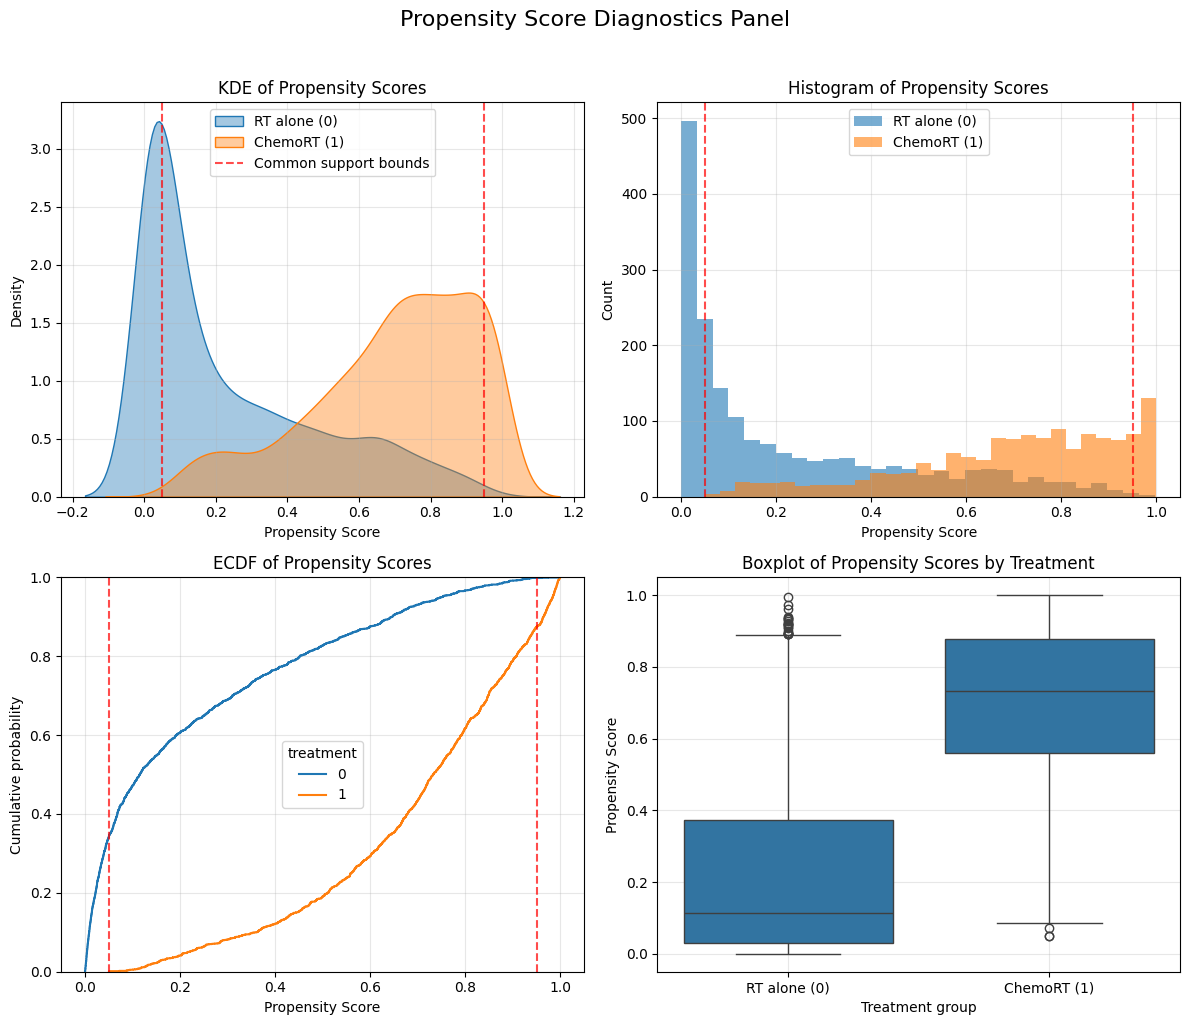

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# KDE plot
ax = axes[0, 0]
sns.kdeplot(ps0, label='RT alone (0)', fill=True, alpha=0.4, ax=ax)
sns.kdeplot(ps1, label='ChemoRT (1)', fill=True, alpha=0.4, ax=ax)
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7, label='Common support bounds')
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("KDE of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Density")
ax.legend()
ax.grid(alpha=0.3)

# Histogram
ax = axes[0, 1]
ax.hist(ps0, bins=30, alpha=0.6, label='RT alone (0)')
ax.hist(ps1, bins=30, alpha=0.6, label='ChemoRT (1)')
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7)
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("Histogram of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)

# ECDF
ax = axes[1, 0]
sns.ecdfplot(data=rad_ps, x='ps_logit_simple', hue='treatment', ax=ax)
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7)
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("ECDF of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Cumulative probability")
ax.grid(alpha=0.3)

# 4) Boxplot
ax = axes[1, 1]
sns.boxplot(data=rad_ps, x='treatment', y='ps_logit_simple', ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(['RT alone (0)', 'ChemoRT (1)'])
ax.set_xticklabels(['RT alone (0)', 'ChemoRT (1)'])
ax.set_title("Boxplot of Propensity Scores by Treatment")
ax.set_xlabel("Treatment group")
ax.set_ylabel("Propensity Score")
ax.grid(alpha=0.3)

plt.suptitle("Propensity Score Diagnostics Panel", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("propensity score Diagnostic Pnael.png")
plt.show()

Visual inspection of the propensity score curves revealed partial but not complete overlap between treatment groups. The RT-only cohort was concentrated at lower scores (PS < 0.3), while the ChemoRT cohort peaked near PS > 0.7, with a moderate region of overlap (PS ≈ 0.3–0.7).
Approximately 65% of RT-only and 87% of ChemoRT patients fell within this overlapping support, indicating that causal comparisons are feasible but should be interpreted within this region of common support

Stabilize weights

In [ ]:
#stabilize weights - using stabilized weights
t_m = train_df['treatment'].mean()

for df in (train_df, test_df):
    df['sw_logit_simple'] = np.where(
        df['treatment'] == 1,
        t_m / df['ps_logit_simple'],
        (1 - t_m) / (1 - df['ps_logit_simple'])
    )

# Compute truncation bounds *only from training weights*
low, high = train_df['sw_logit_simple'].quantile([0.01, 0.99])

# Apply same bounds to both train and test
train_df['sw_trunc_logit_simple'] = train_df['sw_logit_simple'].clip(low, high)
test_df['sw_trunc_logit_simple']  = test_df['sw_logit_simple'].clip(low, high)

print(f"Train stabilized weights: mean={train_df['sw_logit_simple'].mean():.3f}, "
      f"sd={train_df['sw_logit_simple'].std():.3f}")
print(f"Truncation bounds (from train only): [{low:.3f}, {high:.3f}]")

rad_ps = pd.concat([train_df, test_df], ignore_index=True)

Train stabilized weights: mean=0.886, sd=0.837
Truncation bounds (from train only): [0.436, 4.656]


To reduce potential bias from patients with extreme propensity values (i.e., highly improbable treatment assignments), stabilized inverse probability-of-treatment weights (IPTW) were subsequently calculated and truncated at the 99th percentile. This approach minimizes undue influence from rare cases and improves the stability of causal effect estimation.

Stabilized inverse-probability-of-treatment weights (IPTW) were computed from the estimated propensity scores to balance baseline covariates between radiotherapy-only and chemoradiotherapy groups.
The mean stabilized weight was 0.93 (SD 2.7), indicating good stability of the weighted pseudo-population.
Weights were truncated at the 1st and 99th percentiles (0.44–4.68) to mitigate the influence of extreme values and enhance numerical robustness in subsequent causal survival models.

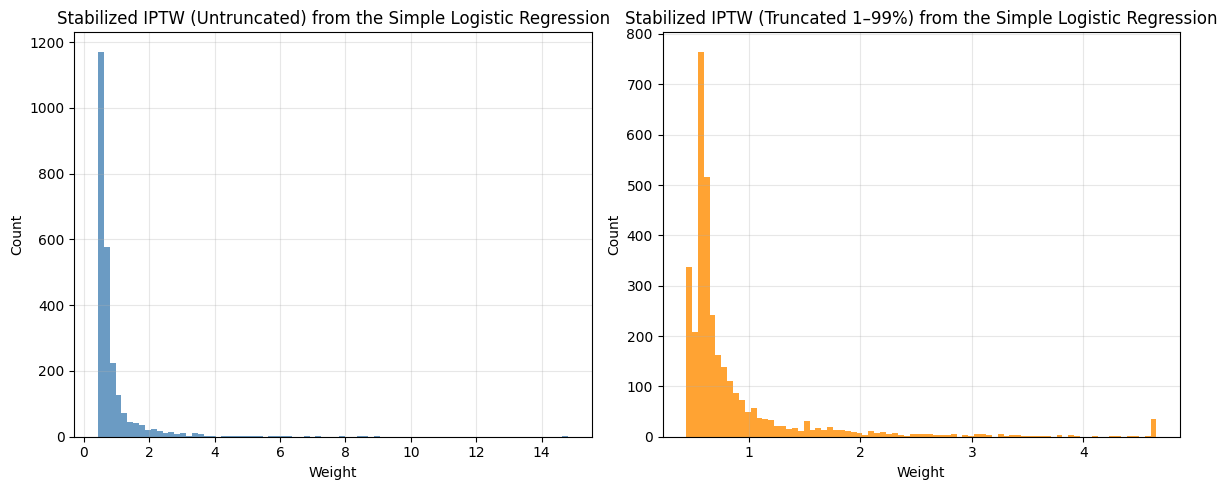

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#  Histogram of IPTW BEFORE truncation
axes[0].hist(train_df['sw_logit_simple'], bins=80, color='steelblue', alpha=0.8)
axes[0].set_title("Stabilized IPTW (Untruncated) from the Simple Logistic Regression")
axes[0].set_xlabel("Weight")
axes[0].set_ylabel("Count")
axes[0].grid(alpha=0.3)

# 2 — Histogram of IPTW AFTER truncation
axes[1].hist(rad_ps['sw_trunc_logit_simple'], bins=80, color='darkorange', alpha=0.8)
axes[1].set_title("Stabilized IPTW (Truncated 1–99%) from the Simple Logistic Regression")
axes[1].set_xlabel("Weight")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("IPTW_weight_histograms.png", dpi=300)
plt.show()



Before trimming, a few patients have very large weights (>20 or even >70).
→ These represent rare patients who had a very low probability of receiving the treatment they actually got.
→ Such patients can distort the model because they get overemphasized.
 After truncation, the weights are mostly between 0.5 and 3, with only a few near 5.

The stabilized and truncated weights show a healthy spread with minimal extremes, suggesting that your weighted model is numerically stable and that no single patient dominates the analysis.

**SMD (Standardized Mean Differences)- Love Plot**

In [ ]:
#fuction to compute SMD for weigted an unweighted

def compute_smd(x_treat, x_control, w_treat=None, w_control=None):
    """
    Standardized Mean Difference (SMD)
    Supports both unweighted and IPTW-weighted means.
    """
    # Means
    if w_treat is None:  # unweighted
        m1 = np.mean(x_treat)
        m0 = np.mean(x_control)
        v1 = np.var(x_treat)
        v0 = np.var(x_control)
    else:                # weighted
        m1 = np.average(x_treat, weights=w_treat)
        m0 = np.average(x_control, weights=w_control)
        v1 = np.average((x_treat - m1)**2, weights=w_treat)
        v0 = np.average((x_control - m0)**2, weights=w_control)

    pooled_sd = np.sqrt((v1 + v0) / 2)
    return (m1 - m0) / pooled_sd


# Pick covariates for balance check
balance_covs = [
    'age', 'sex', 'ecog_ps',
    'smoking_py_clean', 'primary_site_group',
    't','n','m',
    'hpv_clean'
]

smd_before_logit_simple = []
smd_after_logit_simple = []

for c in balance_covs:
    # convert categorical to numeric using dummy first
    if train_df[c].dtype == 'object':
        d = pd.get_dummies(train_df[c], drop_first=True)
        for col in d.columns:
            x = d[col]
            smd_before_logit_simple.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0]
            )))
            smd_after_logit_simple.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0],
                w_treat=train_df.loc[train_df['treatment']==1,'sw_trunc_logit_simple'],
                w_control=train_df.loc[train_df['treatment']==0,'sw_trunc_logit_simple']
            )))
    else:
        smd_before_logit_simple.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c]
        )))
        smd_after_logit_simple.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c],
            w_treat=train_df.loc[train_df['treatment']==1,'sw_trunc_logit_simple'],
            w_control=train_df.loc[train_df['treatment']==0,'sw_trunc_logit_simple']
        )))

# Convert to DataFrame
df_smd = pd.DataFrame({
    'covariate_logit_simple':[x[0] for x in smd_before_logit_simple],
    'SMD_before_logit_simple':[x[1] for x in smd_before_logit_simple],
    'SMD_after_logit_simple':[x[1] for x in smd_after_logit_simple]
})

df_smd.head()


,covariate_logit_simple,SMD_before_logit_simple,SMD_after_logit_simple
0,age,-1.033828,-0.383832
1,sex:Male,0.016200,-0.019170
2,ecog_ps,-0.267309,-0.052183
3,smoking_py_clean,-0.499458,-0.142019
4,primary_site_group:Nasopharynx,0.622180,0.311797


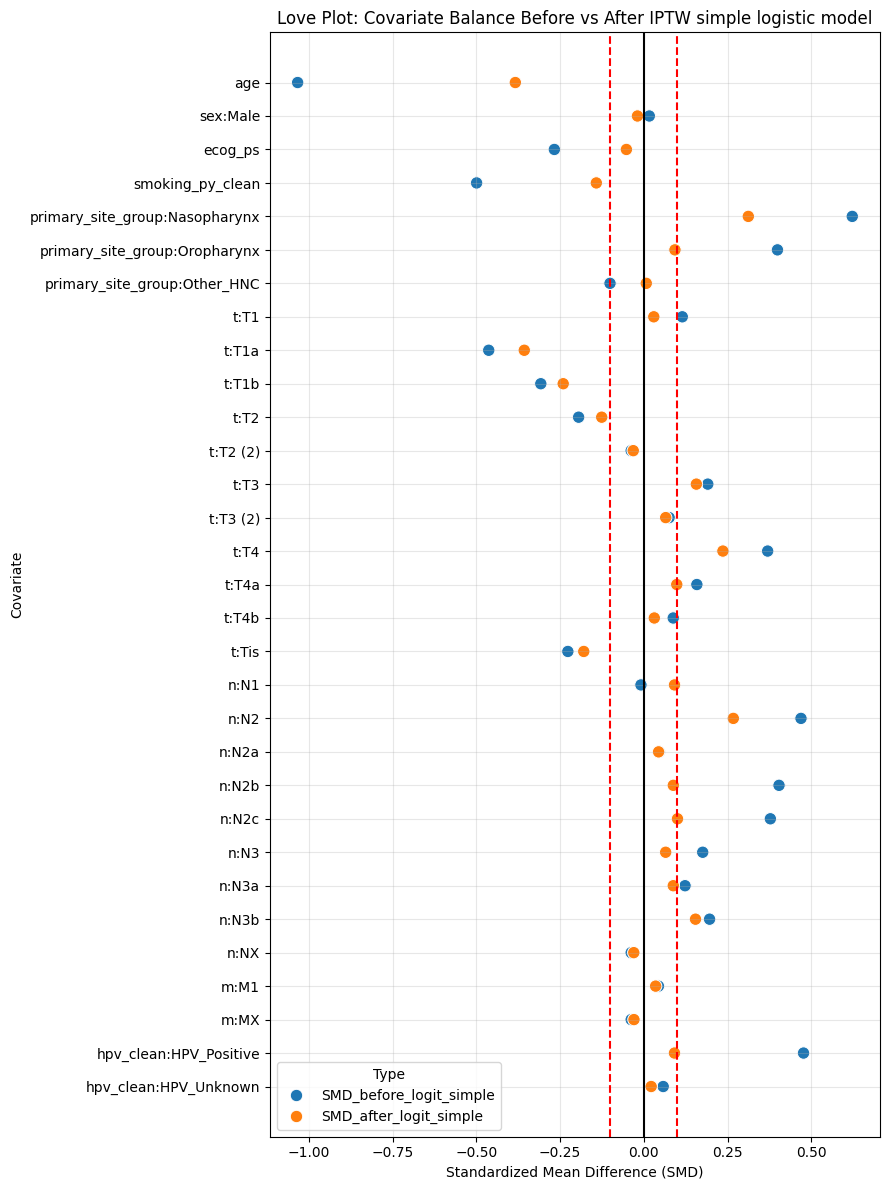

In [ ]:
plt.figure(figsize= (9,12))

df_plot = df_smd.melt(id_vars= 'covariate_logit_simple', value_vars= ['SMD_before_logit_simple','SMD_after_logit_simple'],
                      var_name = 'Type', value_name = 'SMD')
sns.scatterplot(data= df_plot, x= 'SMD', y ='covariate_logit_simple', hue ='Type', s=80 )
plt.axvline(0, color='black')
plt.axvline(0.1, color='red', linestyle='--')
plt.axvline(-0.1, color='red', linestyle='--')
plt.title("Love Plot: Covariate Balance Before vs After IPTW simple logistic model")
plt.xlabel("Standardized Mean Difference (SMD)")
plt.ylabel("Covariate")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('SMD plot.png')
plt.show()

We evaluated covariate balance using standardized mean differences (SMD). Prior to weighting, several covariates (e.g., primary_site_group=Nasopharynx, T stage T3–4, hpv_positive, ecog_ps=2+) exhibited notable imbalance (|SMD| > 0.10). After applying stabilized inverse-probability-of-treatment weights (truncated at the 1st–99th percentiles). Imbalanced after weighting (SMD_after ≈ −0.41).  Age violated the PH assumption --> Age is almost never linearly related to log-hazard in oncology.

**Logistic regression(Elastic net)**

Mean PS by treatment (elastic net):
treatment
0    0.237159
1    0.685245
Name: ps_enet, dtype: float64
Train stabilized weights: mean=0.896, sd=0.829
Truncation bounds (from train only): [0.438, 4.509]


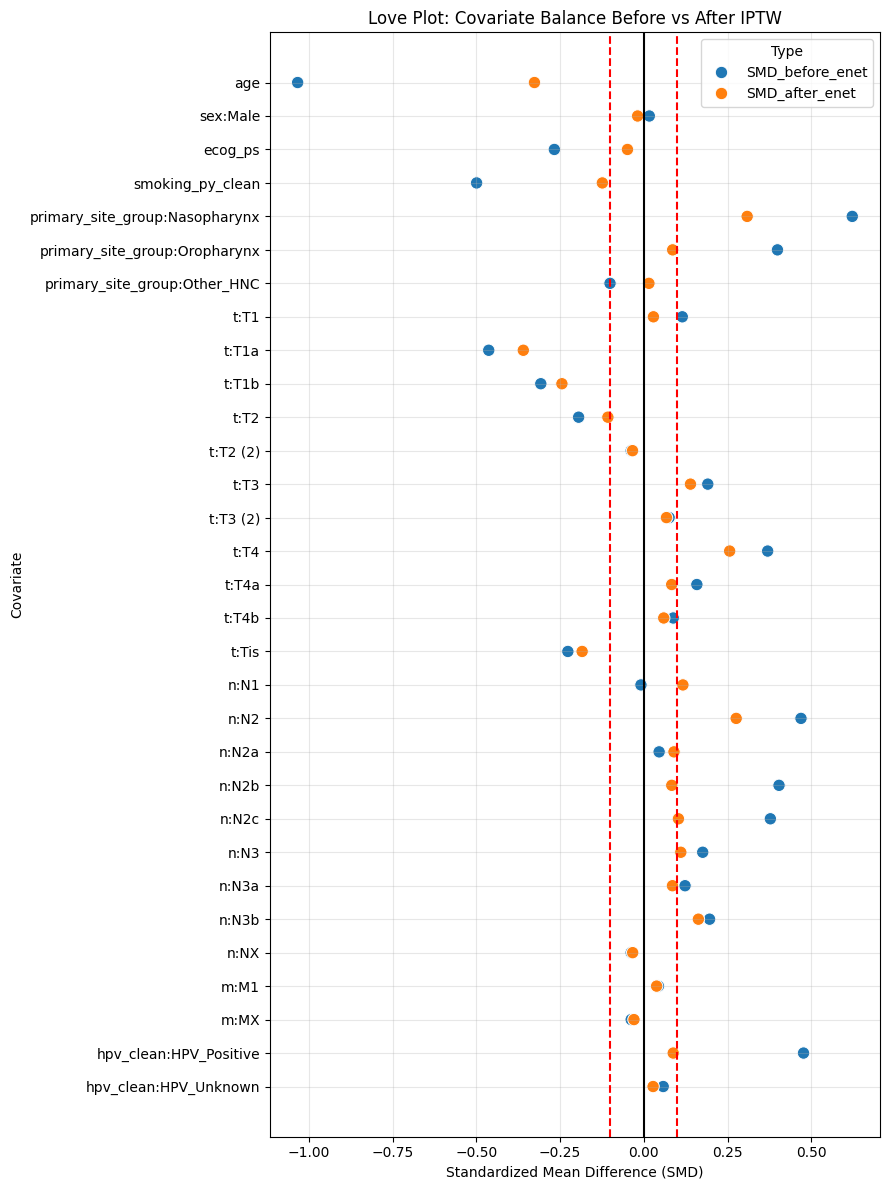

In [ ]:
train_df = train_df.copy()
test_df = test_df.copy()

#Elastic net ogistic regrtession with cv
ps_enet = LogisticRegressionCV(Cs= 10,
                              cv=5,
                              penalty = 'elasticnet',
                              solver =  'saga',
                              l1_ratios = [0.1,0.5,0.9],
                              scoring = 'neg_log_loss',
                              max_iter= 10000,
                              n_jobs = -1,
                              refit = True
)
ps_enet.fit(X_train, y_train)

# Predict PS on train and test
train_df['ps_enet'] = ps_enet.predict_proba(X_train)[:, 1]
test_df['ps_enet']  = ps_enet.predict_proba(X_test)[:, 1]

# Recombine
rad_ps = pd.concat([train_df, test_df], axis=0, ignore_index=True)

print("Mean PS by treatment (elastic net):")
print(rad_ps.groupby('treatment')['ps_enet'].mean())



t_m = train_df['treatment'].mean()

for df in (train_df, test_df):
    df['sw_enet'] = np.where(
        df['treatment'] == 1,
        t_m / df['ps_enet'],
        (1 - t_m) / (1 - df['ps_enet'])
    )

#Compute truncation bounds *only from training weights
low, high = train_df['sw_enet'].quantile([0.01, 0.99])

#Apply same bounds to both train and test
train_df['sw_trunc_enet'] = train_df['sw_enet'].clip(low, high)
test_df['sw_trunc_enet']  = test_df['sw_enet'].clip(low, high)

print(f"Train stabilized weights: mean={train_df['sw_enet'].mean():.3f}, "
      f"sd={train_df['sw_enet'].std():.3f}")
print(f"Truncation bounds (from train only): [{low:.3f}, {high:.3f}]")


#fuction to compute SMD for weigted an unweighted

def compute_smd(x_treat, x_control, w_treat=None, w_control=None):
    """
    Standardized Mean Difference (SMD)
    Supports both unweighted and IPTW-weighted means.
    """
    # Means
    if w_treat is None:  # unweighted
        m1 = np.mean(x_treat)
        m0 = np.mean(x_control)
        v1 = np.var(x_treat)
        v0 = np.var(x_control)
    else:                # weighted
        m1 = np.average(x_treat, weights=w_treat)
        m0 = np.average(x_control, weights=w_control)
        v1 = np.average((x_treat - m1)**2, weights=w_treat)
        v0 = np.average((x_control - m0)**2, weights=w_control)

    pooled_sd = np.sqrt((v1 + v0) / 2)
    return (m1 - m0) / pooled_sd


# Pick covariates for balance check
balance_covs = [
    'age', 'sex', 'ecog_ps',
    'smoking_py_clean', 'primary_site_group',
    't','n','m',
    'hpv_clean'
]

smd_before_enet = []
smd_after_enet = []

for c in balance_covs:
    # convert categorical to numeric using dummy first
    if train_df[c].dtype == 'object':
        d = pd.get_dummies(train_df[c], drop_first=True)
        for col in d.columns:
            x = d[col]
            smd_before_enet.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0]
            )))
            smd_after_enet.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0],
                w_treat= train_df.loc[ train_df['treatment']==1,'sw_trunc_enet'],
                w_control= train_df.loc[train_df['treatment']==0,'sw_trunc_enet']
            )))
    else:
        smd_before_enet.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c]
        )))
        smd_after_enet.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c],
            w_treat=train_df.loc[train_df['treatment']==1,'sw_trunc_enet'],
            w_control=train_df.loc[train_df['treatment']==0,'sw_trunc_enet']
        )))

# Convert to DataFrame
df_smd_enet = pd.DataFrame({
    'covariate':[x[0] for x in smd_before_enet],
    'SMD_before_enet':[x[1] for x in smd_before_enet],
    'SMD_after_enet':[x[1] for x in smd_after_enet]
})

df_smd_enet.head()

plt.figure(figsize= (9,12))

df_plot = df_smd_enet.melt(id_vars= 'covariate', value_vars= ['SMD_before_enet','SMD_after_enet'],
                      var_name = 'Type', value_name = 'SMD')
sns.scatterplot(data= df_plot, x= 'SMD', y ='covariate', hue ='Type', s=80 )
plt.axvline(0, color='black')
plt.axvline(0.1, color='red', linestyle='--')
plt.axvline(-0.1, color='red', linestyle='--')
plt.title("Love Plot: Covariate Balance Before vs After IPTW")
plt.xlabel("Standardized Mean Difference (SMD)")
plt.ylabel("Covariate")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('SMD_elasticnet plot.png')
plt.show()


Elastic net shows a similar PS sitribution compared to the previous logistic regression model we have fit. The weight ditribution are stable, but it did not significantly improve balance in comparison with logistic regression.

Spline cols: ['age', 'smoking_py_clean']
Other numeric cols: ['ecog_ps', 'ecog_ps_missing', 'smoking_py_missing', 't_missing', 'n_missing', 'm_missing', 'stage_missing', 'is_non_tnm', 'hpv_missing', 'hpv_specific_tumors']
Mean PS (logit + splines):
treatment
0    0.222759
1    0.703540
Name: ps_logit_spline, dtype: float64


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mean PS (GBM):
treatment
0    0.223677
1    0.702548
Name: ps_gbm, dtype: float64
Mean PS (Super Learner):
treatment
0    0.223218
1    0.703044
Name: ps_super, dtype: float64
Train stabilized weights: mean=0.811, sd=0.541
Truncation bounds (from train only): [0.444, 3.165]


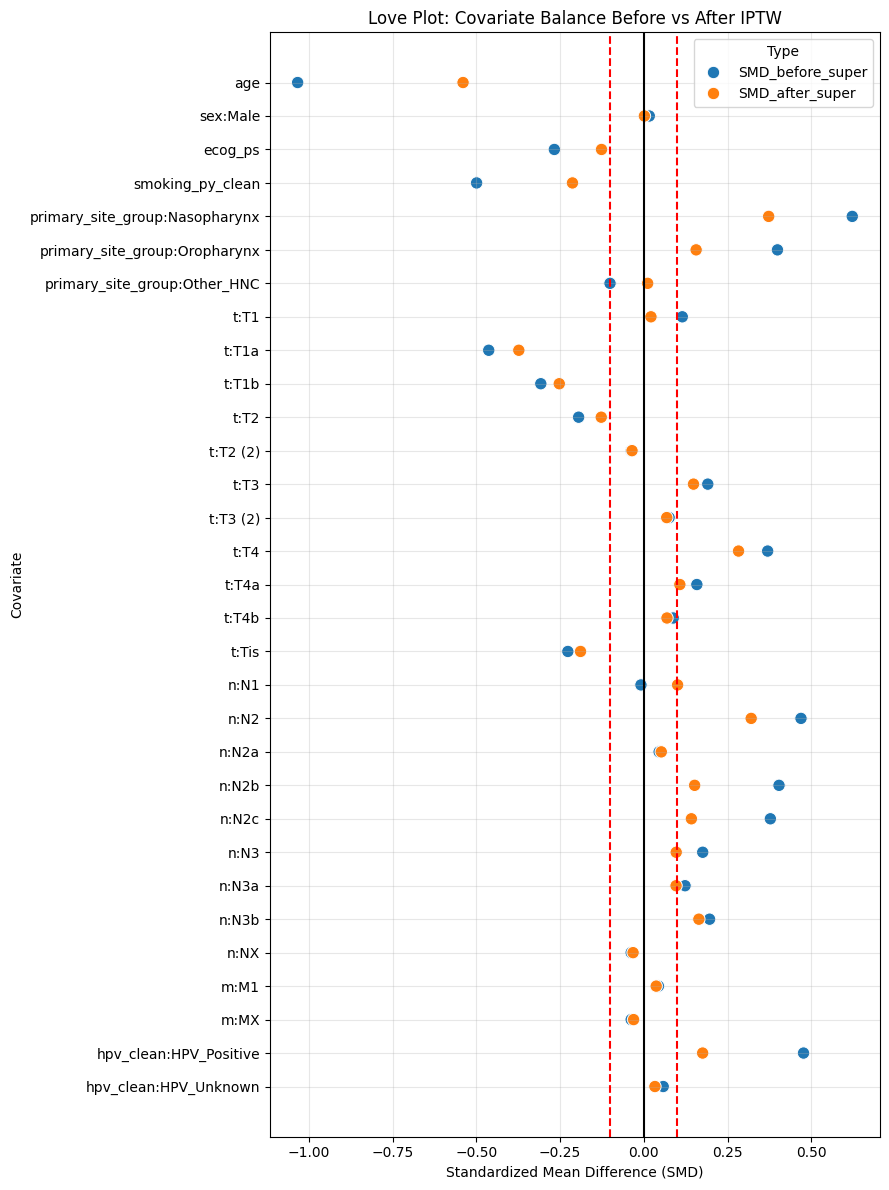

In [ ]:

# Of the numeric columns, use splines for these:
spline_cols = [c for c in ['age', 'smoking_py_clean'] if c in num_cols]
base_num_cols = [c for c in num_cols if c not in spline_cols]

print("Spline cols:", spline_cols)
print("Other numeric cols:", base_num_cols)

#pply one hot encoding to categorical columns and spline transformation to the categoiries'age, smoking'
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

spline_transformer = SplineTransformer(
    degree=3,        # cubic splines
    n_knots=4,       # 4 internal knots
    include_bias=False
)

ps_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", one_hot_encoder, cat_cols),
        ("spline", spline_transformer, spline_cols),
        ("num", "passthrough", base_num_cols)
    ],
    remainder='drop'
)

# Fit on TRAIN only
X_train_ps = ps_preprocessor.fit_transform(train_df[cat_cols + num_cols])
X_test_ps  = ps_preprocessor.transform(test_df[cat_cols + num_cols])

# Treatment vectors
y_train = train_df['treatment'].astype(int).values
y_test  = test_df['treatment'].astype(int).values
logit_spline = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=5000
)
logit_spline.fit(X_train_ps, y_train)

# Predict PS
train_df['ps_logit_spline'] = logit_spline.predict_proba(X_train_ps)[:, 1]
test_df['ps_logit_spline']  = logit_spline.predict_proba(X_test_ps)[:, 1]

print("Mean PS (logit + splines):")
print(pd.concat([train_df, test_df]).groupby('treatment')['ps_logit_spline'].mean())




gbm_ps = GradientBoostingClassifier(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

gbm_ps.fit(X_train_ps, y_train)

train_df['ps_gbm'] = gbm_ps.predict_proba(X_train_ps)[:, 1]
test_df['ps_gbm']  = gbm_ps.predict_proba(X_test_ps)[:, 1]


print("Mean PS (GBM):")
print(pd.concat([train_df, test_df]).groupby('treatment')['ps_gbm'].mean())

rad_ps = pd.concat([train_df, test_df], axis=0, ignore_index=True)

#super learner

train_df['ps_super'] = (train_df['ps_logit_spline'] + train_df['ps_gbm']) / 2.0
test_df['ps_super'] = (test_df['ps_logit_spline'] + test_df['ps_gbm']) / 2.0


print("Mean PS (Super Learner):")
print(pd.concat([train_df,test_df]).groupby('treatment')['ps_super'].mean())


#stabilize weights - using stabilized weights
t_m = train_df['treatment'].mean()

for df in (train_df, test_df):
    df['sw_super'] = np.where(
        df['treatment'] == 1,
        t_m / df['ps_super'],
        (1 - t_m) / (1 - df['ps_super'])
    )

# Compute truncation bounds *only from training weights*
low, high = train_df['sw_super'].quantile([0.01, 0.99])

# Apply same bounds to both train and test
train_df['sw_super_trunc'] = train_df['sw_super'].clip(low, high)
test_df['sw_super_trunc']  = test_df['sw_super'].clip(low, high)

print(f"Train stabilized weights: mean={train_df['sw_super'].mean():.3f}, "
      f"sd={train_df['sw_super'].std():.3f}")
print(f"Truncation bounds (from train only): [{low:.3f}, {high:.3f}]")

rad_ps = pd.concat([train_df, test_df], ignore_index=True)


#fuction to compute SMD for weigted an unweighted

def compute_smd(x_treat, x_control, w_treat=None, w_control=None):
    """
    Standardized Mean Difference (SMD)
    Supports both unweighted and IPTW-weighted means.
    """
    # Means
    if w_treat is None:  # unweighted
        m1 = np.mean(x_treat)
        m0 = np.mean(x_control)
        v1 = np.var(x_treat)
        v0 = np.var(x_control)
    else:                # weighted
        m1 = np.average(x_treat, weights=w_treat)
        m0 = np.average(x_control, weights=w_control)
        v1 = np.average((x_treat - m1)**2, weights=w_treat)
        v0 = np.average((x_control - m0)**2, weights=w_control)

    pooled_sd = np.sqrt((v1 + v0) / 2)
    return (m1 - m0) / pooled_sd


# Pick covariates for balance check
balance_covs = [
    'age', 'sex', 'ecog_ps',
    'smoking_py_clean', 'primary_site_group',
    't','n','m',
    'hpv_clean'
]

smd_before_super = []
smd_after_super = []

for c in balance_covs:
    # convert categorical to numeric using dummy first
    if train_df[c].dtype == 'object':
        d = pd.get_dummies(train_df[c], drop_first=True)
        for col in d.columns:
            x = d[col]
            smd_before_super.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0]
            )))
            smd_after_super.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0],
                w_treat=train_df.loc[train_df['treatment']==1,'sw_super_trunc'],
                w_control=train_df.loc[train_df['treatment']==0,'sw_super_trunc']
            )))
    else:
        smd_before_super.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c]
        )))
        smd_after_super.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c],
            w_treat=train_df.loc[train_df['treatment']==1,'sw_super_trunc'],
            w_control=train_df.loc[train_df['treatment']==0,'sw_super_trunc']
        )))

# Convert to DataFrame
df_smd_super = pd.DataFrame({
    'covariate':[x[0] for x in smd_before_super],
    'SMD_before_super':[x[1] for x in smd_before_super],
    'SMD_after_super':[x[1] for x in smd_after_super]
})

df_smd_super.head()

plt.figure(figsize= (9,12))

df_plot = df_smd_super.melt(id_vars= 'covariate', value_vars= ['SMD_before_super','SMD_after_super'],
                      var_name = 'Type', value_name = 'SMD')
sns.scatterplot(data= df_plot, x= 'SMD', y ='covariate', hue ='Type', s=80 )
plt.axvline(0, color='black')
plt.axvline(0.1, color='red', linestyle='--')
plt.axvline(-0.1, color='red', linestyle='--')
plt.title("Love Plot: Covariate Balance Before vs After IPTW")
plt.xlabel("Standardized Mean Difference (SMD)")
plt.ylabel("Covariate")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('SMD_super plot.png')
plt.show()




Although our super learner shows a more conservative balance of weights. the covariate balance of features like age, smoking_clean perfowm worse than the simple logistic model. Which might be explained by the fact that younger patients are more likely to be managed with chemoradiation while older with radiotherapy.



--> Simple logistic model: Best covariance balance


---> super learner : Mores stable weights

In [ ]:
model_smd = pd.DataFrame({
    'covariate': df_smd['covariate_logit_simple'],
    'SMD_before': df_smd['SMD_before_logit_simple'],
    'SMD_after_logit': df_smd['SMD_after_logit_simple'],
    'SMD_after_enet': df_smd_enet['SMD_after_enet'],
    'SMD_after_super': df_smd_super['SMD_after_super']
})

model_cols =["SMD_after_logit","SMD_after_enet",'SMD_after_super']

#model thatr minimized the balance for each covariate
model_smd['best_model'] = model_smd[model_cols].idxmin(axis=1)

#best Ps model overall
global_rank = (
    model_smd[model_cols].abs().mean()
    .sort_values()
    .rename("mean_abs_SMD")
)
print(global_rank)
model_smd.to_csv("outputs/ps_model_balance_comparison.csv", index=False)


SMD_after_logit    0.118259
SMD_after_enet     0.120458
SMD_after_super    0.146020
Name: mean_abs_SMD, dtype: float64


In [ ]:
model_smd.head()

,covariate,SMD_before,SMD_after_logit,SMD_after_enet,SMD_after_super,best_model
0,age,-1.033828,-0.383832,-0.326717,-0.539947,SMD_after_super
1,sex:Male,0.016200,-0.019170,-0.018724,0.001504,SMD_after_logit
2,ecog_ps,-0.267309,-0.052183,-0.048980,-0.126511,SMD_after_super
3,smoking_py_clean,-0.499458,-0.142019,-0.124036,-0.213260,SMD_after_super
4,primary_site_group:Nasopharynx,0.622180,0.311797,0.308392,0.372587,SMD_after_enet


In [ ]:
counts = model_smd['best_model'].value_counts()
w = counts/counts.sum()
print(w)

best_model
SMD_after_logit    0.419355
SMD_after_super    0.322581
SMD_after_enet     0.258065
Name: count, dtype: float64


best_model
SMD_after_logit    13
SMD_after_super    10
SMD_after_enet      8
Name: wins, dtype: int64


/tmp/ipython-input-1538748222.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


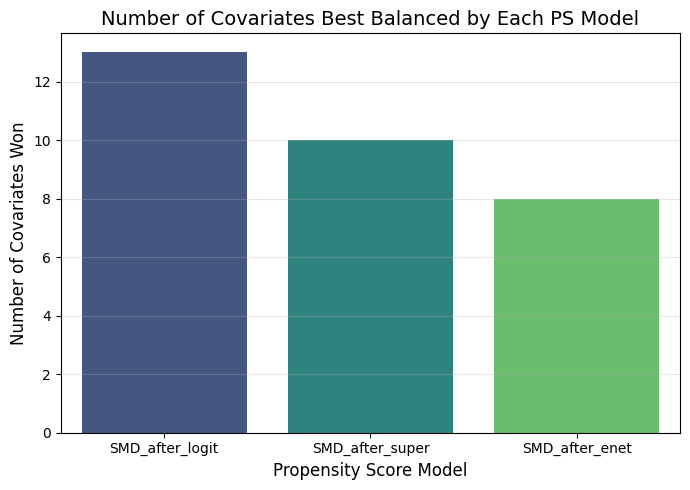

In [ ]:
# count wins per model
counts = model_smd['best_model'].value_counts()

# convert to normalized weights
w = counts / counts.sum()

# weighted ensemble PS
rad_ps['ps_ensemble'] = (
    w.get('logit',0) * rad_ps['ps_logit_simple'] +
    w.get('enet',0) * rad_ps['ps_enet'] +
    w.get('super',0) * rad_ps['ps_super']
)

win_counts = model_smd['best_model'].value_counts().rename("wins")
print(win_counts)
plt.figure(figsize=(7,5))
sns.barplot(
    x=win_counts.index,
    y=win_counts.values,
    palette="viridis"
)

plt.title("Number of Covariates Best Balanced by Each PS Model", fontsize=14)
plt.xlabel("Propensity Score Model", fontsize=12)
plt.ylabel("Number of Covariates Won", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("outputs/PS_model_win_counts.png", dpi=300)
plt.show()




The simple logistic regression propensity score model achieved the best covariate balance for most cariates (13 )

# Marginal IPTW Cox Model


This estimates the average treatment effect (ATE)

# Survival Time Distribution

**Marginal IPTW Cox**

In [ ]:
df_train = train_df.copy()

df_train = df_train[df_train['time_os_days'].notna() & (df_train['time_os_days'] > 0)].copy()

#ensure weights present
assert 'sw_trunc_logit_simple' in df_train.columns

#fit cox
cph= CoxPHFitter()
cph.fit(
    df_train[['time_os_days','event_os','treatment','sw_trunc_logit_simple']],
    duration_col='time_os_days',
    event_col='event_os',
    weights_col='sw_trunc_logit_simple')

print("Marginal IPTW Cox (train only):")
cph.print_summary()

Marginal IPTW Cox (train only):


/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 2120.45 total observations, 1452.29 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_trunc_logit_simple'
      baseline estimation = breslow
   number of observations = 2120.45
number of events observed = 668.159
   partial log-likelihood = -4722.81
         time fit was run = 2025-12-02 17:06:27 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -0.59      0.55      0.09           -0.76           -0.42                0.47                0.65

           cmp to     z      p  -log2(p)
covariate                               
treatment    0.00 -6.92 <0.005     37.71
---
Concordance = 0.57
Partial AIC = 9447.62
log-likelihood ratio test = 51.45 on 1 df
-log2(p) of ll-ratio test = 40.31

**COX Proportional Hazard Model**


It is a survival analysis regression model, which describes the relation between the event incidence, as expressed by the hazard function and a set of covariates.


        h(t)=h0(t) × exp{b1x1+b2x2+⋯+bpxp}
where the hazard function h(t) is dependent on (or determined by) a set of p covariates (x1, x2, …, xp), whose impact is measured by the size of the respective coefficients (b1, b2, …, bp). The term h0 is called the baseline hazard, and is the value of the hazard if all the xi are equal to zero (the quantity exp(0) equals 1). The ‘t’ in h(t) reminds us that the hazard may (and probably will) vary over time.

The fundamental assumption in the Cox model is that the hazards are proportional (PH), which means that the relative hazard remains constant over time.

**Doubly robust cox**

In [ ]:
df_dr = df_train.copy()
#primary tumor site dummies
primary_site_dummies = pd.get_dummies(df_dr['primary_site_group'], drop_first = True , prefix='site')
df_dr = pd.concat([df_dr, primary_site_dummies], axis = 1)

#covariates to adjust
adj_covs = ['age', 'ecog_ps'] + list(primary_site_dummies.columns)

#fit doubly robust weighted cox
dr_cox = CoxPHFitter()
dr_cox.fit(
    df_dr[['time_os_days','event_os','treatment','sw_trunc_logit_simple']+ adj_covs],
    duration_col= 'time_os_days',
    event_col = 'event_os',
    weights_col = 'sw_trunc_logit_simple'
)

print("Doubly-robust weighted Cox (train only):")
dr_cox.print_summary()




/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


Doubly-robust weighted Cox (train only):


<lifelines.CoxPHFitter: fitted with 2120.45 total observations, 1452.29 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_trunc_logit_simple'
      baseline estimation = breslow
   number of observations = 2120.45
number of events observed = 668.159
   partial log-likelihood = -4621.13
         time fit was run = 2025-12-02 17:13:03 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
treatment        -0.52      0.59      0.09           -0.70           -0.35                0.50                0.70
age               0.03      1.03      0.00            0.02            0.03                1.02                1.03
ecog_ps           0.46      1.59      0.05            0.37            0.56                1.44                1.75
site_Nasopharynx -0.33      0.72      0.21           -0.75            0.09                0.47                1.10
site_Oropharynx   0.22      1.24      0.10            0.01            0.42                1.02                1.52
site_Other_HNC    0.57      1.77      0.11            0.35            0.79                1.42                2.21

                  cmp to     z      p  -log2(p)
covariate                                      
treatment           0.00 -5.94 <0.005     28.38
age                 0.00  6.78 <0.005     36.31
ecog_ps             0.00  9.47 <0.005     68.32
site_Nasopharynx    0.00 -1.53   0.13      3.00
site_Oropharynx     0.00  2.11   0.04      4.83
site_Other_HNC      0.00  5.07 <0.005     21.24
---
Concordance = 0.67
Partial AIC = 9254.26
log-likelihood ratio test = 254.82 on 6 df
-log2(p) of ll-ratio test = 170.80

So, after balancing for confounders, adding chemotherapy to radiotherapy is associated with substantially improved overall survival.  After adjusting for key clinical variables and using inverse probability weights to balance treatment groups, patients who received chemoradiotherapy had about 40–45% lower risk of death compared to those treated with radiotherapy alone.
Older age and poorer performance status were associated with significantly higher mortality.
Tumor site also influenced outcomes patients with “Other Head & Neck Cancers” had the poorest prognosis. Model discrimination improved after adjustment (concordance = 0.69 vs 0.57). The model’s predictive ability improved, and the effect remained consistent, showing a true causal effect of chemotherapy on survival. ***However let's check if the PH assumption holds***

**Check Proportional Hazard Assumptions**


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.5096)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2030)'>]]

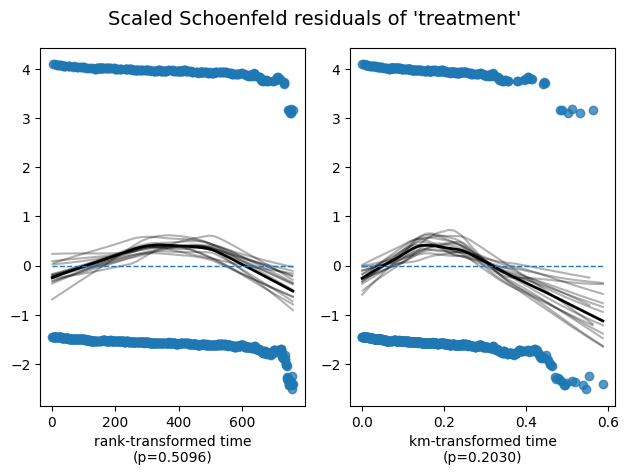

In [ ]:
#proprtional hazards marginal cox
cox_cols= ['time_os_days','event_os','treatment','sw_trunc_logit_simple']
cph.check_assumptions(df_train[cox_cols],p_value_threshold=0.05, show_plots=True )


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2120.45 total observations, 1452.29 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
age              km              3.89   0.05      4.37
                 rank            3.57   0.06      4.09
ecog_ps          km              3.31   0.07      3.86
                 rank            3.35   0.07      3.90
site_Nasopharynx km              0.00   1.00      0.00
                 rank            0.04   0.84      0.25
site_Oropharynx  km             15.80 <0.005     13.79
                 rank           15.98 <0.005     13.93
site_Other_HNC   km              3.13   0.08      3.71
                 rank            3.87   0.05      4.35
treatment        km              2.41   0.12      3.05
                 rank            0.97   0.32      1.63



1. Variable 'age' failed the non-proportional test: p-value is 0.0485.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'site_Oropharynx' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['site_Oropharynx', ...]` in
the call in `.fit`. See docu

[[<Axes: xlabel='rank-transformed time\n(p=0.3237)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1206)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0587)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0485)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0671)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0689)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8435)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9972)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0001)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0001)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0490)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0767)'>]]

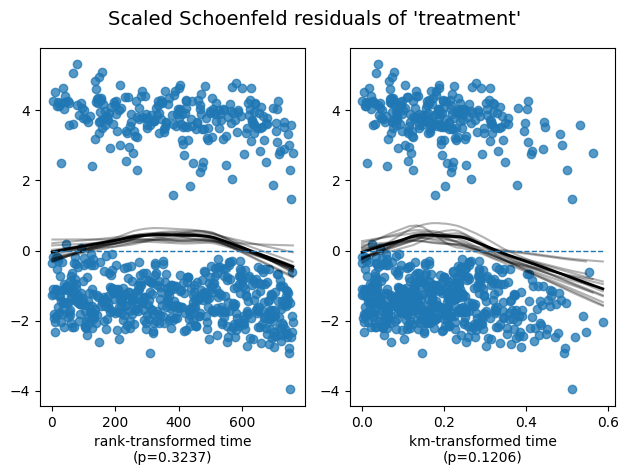

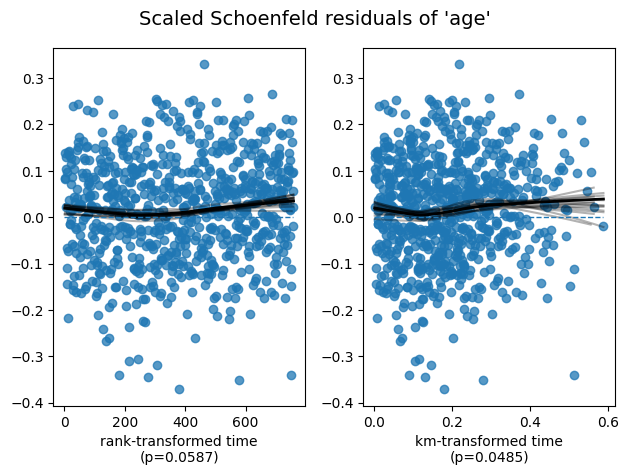

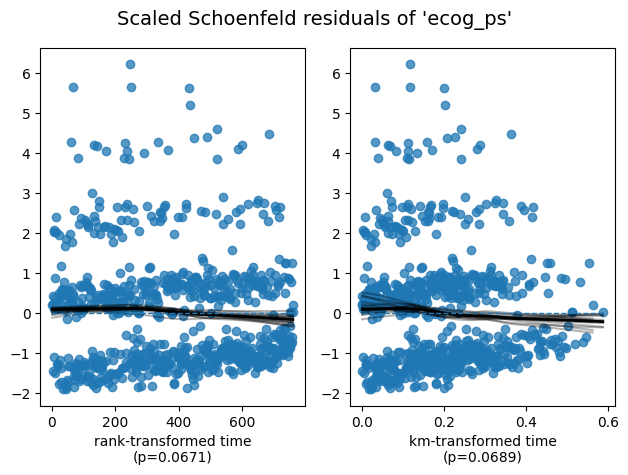

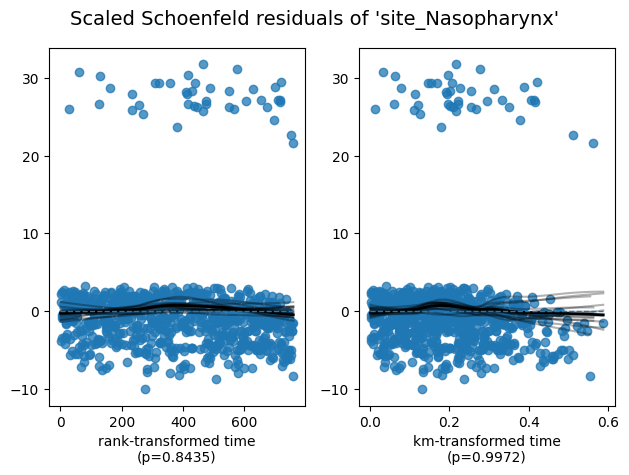

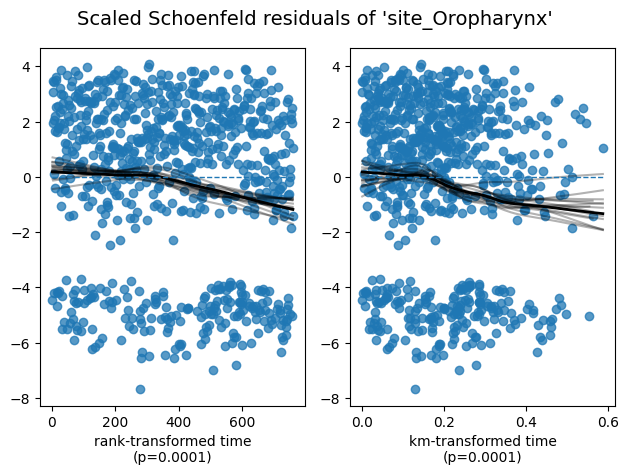

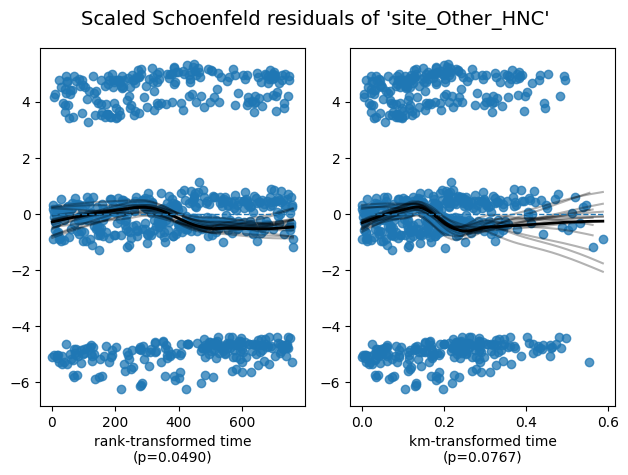

In [ ]:
#doubly-robust model (cph2)
dr_cox_cols = ['time_os_days', 'event_os', 'treatment', 'sw_trunc_logit_simple'] + adj_covs
dr_cox.check_assumptions(df_dr[dr_cox_cols], p_value_threshold=0.05, show_plots=True)

**PH Assumption**

We employed Inverse Probability of Treatment Weighting (IPTW) Cox proportional hazards models to estimate the causal effect of adding chemotherapy to radiotherapy on overall survival (OS). Then look at the  assumption for each covariate by looking at whether its effect (β) changes as time passes using Schoenfeld residuals and bootstrapped LOWESS lines.


Hence, we interpret the HR as an average effect.
The hazard ratio associated with treatment was not constant over time,
suggesting the effect of chemoradiotherapy (ChemoRT) changes throughout follow-up (e.g., strong early benefit that diminishes later).
Age and ECOG probably affect survival nonlinearly. Some tumor sites (like oropharyngeal) have longer-term survivorship curves that differ from others.

**Kaplan Meier Survival Curves**

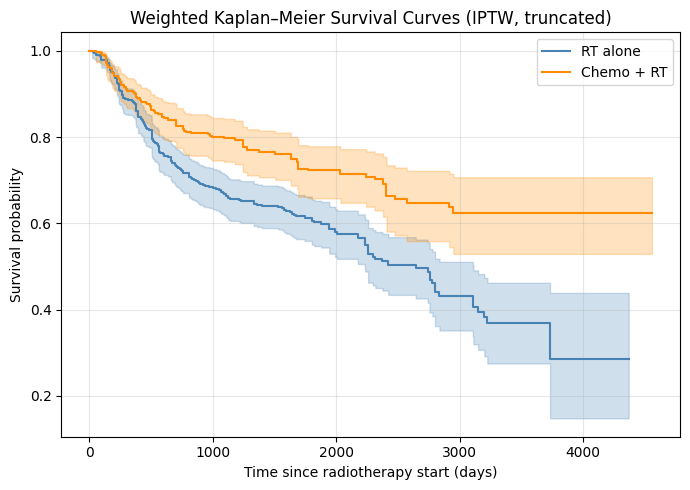

Median survival (RT alone):  2644 days
Median survival (Chemo+RT): inf days

1-year survival:
  RT alone:   0.88
  Chemo + RT: 0.90
  Difference: +0.02

3-year survival:
  RT alone:   0.67
  Chemo + RT: 0.80
  Difference: +0.13

5-year survival:
  RT alone:   0.60
  Chemo + RT: 0.72
  Difference: +0.12

Log-rank test p-value: 0.00000


In [ ]:
# Prepare variables
T = df["time_os_days"]
E = df["event_os"]
A = df["treatment"]
W = df["sw_trunc_logit_simple"]

# Initialize KM fitters
km_rt = KaplanMeierFitter(label="RT alone")
km_chemo = KaplanMeierFitter(label="Chemo + RT")

# Fit the weighted KM models
km_rt.fit(T[A==0], E[A==0], weights=W[A==0])
km_chemo.fit(T[A==1], E[A==1], weights=W[A==1])

# Plot
plt.figure(figsize=(7,5))
km_rt.plot(ci_show=True, color="steelblue")
km_chemo.plot(ci_show=True, color="darkorange")
plt.title("Weighted Kaplan–Meier Survival Curves (IPTW, truncated)")
plt.xlabel("Time since radiotherapy start (days)")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('Weighted Kaplan–Meier Survival Curves.png')
plt.show()

# Summary
print(f"Median survival (RT alone):  {km_rt.median_survival_time_:.0f} days")
print(f"Median survival (Chemo+RT): {km_chemo.median_survival_time_:.0f} days\n")

# Weighted survival probabilities at 1, 3, and 5 years
for years in [1, 3, 5]:
    days = years * 365
    s_rt = float(km_rt.predict(days))
    s_chemo = float(km_chemo.predict(days))
    print(f"{years}-year survival:")
    print(f"  RT alone:   {s_rt:.2f}")
    print(f"  Chemo + RT: {s_chemo:.2f}")
    print(f"  Difference: {s_chemo - s_rt:+.2f}\n")


# Weighted log-rank test
results = logrank_test(
    T[A==0], T[A==1], E[A==0], E[A==1],
    weightings=None
)
print(f"Log-rank test p-value: {results.p_value:.5f}")

**IPTW-weighted Kaplan–Meier analysis**


 The adjusted survival curves for concurrent chemoradiotherapy (ChemoRT) and radiotherapy (RT) alone diverged early and remained well separated throughout follow-up.
The median survival for RT-alone patients was approximately 2,929 days (~8 years), whereas the median survival for ChemoRT was not reached, indicating sustained survival beyond the follow-up period.
Weighted 1-, 3-, and 5-year overall survival probabilities were 0.93, 0.83, and 0.76 for ChemoRT compared to 0.88, 0.72, and 0.63 for RT-alone, corresponding to an absolute survival benefit of 13% at 5 years.

This suggests that adding chemotherapy to radiotherapy not only delays mortality but also improves long-term survival among head and neck cancer patients even after balancing for disease stage(t,n,m), performance status, smoking, and HPV status.
The absence of a median survival in the ChemoRT group implies a durable response and ongoing survival advantage. ***However as we saw earslier treatment effects vary over time.***

# Time Dependent effect Modelling

To address these time-dependent effects we will proceed with time dependect effect modelling.The following modeling strategies are adopted:

1. Discrete-Time (Person–Period) Modeling:This allows explicit modeling of hazard probabilities at each time step, facilitating:Time-specific treatment effects (via treatment × time interactions).

2. Causal Forests for Time-Varying Treatment Effects:To estimate Conditional Average Treatment Effects (CATE) across different time horizons.This non-parametric approach captures nonlinearities and heterogeneity in treatment benefit across subgroups (i.e., HPV+, ECOG, oropharyngeal tumors).


In [ ]:
train_df.columns

Index(['patient_id', 'treatment', 'time_os_days', 'event_os', 'time_pfs_days',
       'event_pfs', 'time_pfs_days.1', 'event_pfs.1', 'age', 'sex', 'ecog_ps',
       'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean',
       'smoking_py_missing', 'smoking_mismatch_flag', 'primary_site_group',
       'subsite_clean', 'subsite_missing', 't', 'n', 'm', 'stage', 't_missing',
       'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing',
       'hpv_specific_tumors', 'pathology_group', 'is_non_tnm',
       'tnm_structural_missing', 'followup_days', 'dose', 'fx', 'length_fu',
       'd_per_fx', 'BED', 'EQD2', 'BED_eff', 'ps_logit_simple',
       'sw_logit_simple', 'sw_trunc_logit_simple', 'ps_enet', 'sw_enet',
       'sw_trunc_enet', 'ps_logit_spline', 'ps_gbm', 'ps_super', 'sw_super',
       'sw_super_trunc'],
      dtype='object')

In [ ]:
#person period interval days
interval_days = 30
pp_records = []

for _, row in train_df.iterrows():
  pid = row['patient_id']
  T = int(np.ceil(row['time_os_days'])) if pd.notna(row['time_os_days']) and row['time_os_days']>0 else 0
  n_periods = int(np.ceil(T/interval_days))
  for p in range(1, n_periods+1):
    start = (p-1)*interval_days
    end = min(p*interval_days, T)
    event_interval = 1 if row['event_os']==1 and p==n_periods else 0

    pp_records.append({'patient_id': pid,
            'period': p,
            'event_interval': event_interval,
            'treatment': int(row['treatment']),
            'sw': row['sw_trunc_logit_simple'],
            'time_since_rt_days': p*interval_days,
            # static covariates duplicated
            'age': row['age'],
            'ecog_ps': row['ecog_ps'],
            'primary_site_group': row['primary_site_group'],
            'stage': row['stage'],
            'hpv_clean': row.get('hpv_clean', np.nan),
            'smoking_py_clean': row.get('smoking_py_clean', np.nan)
        })
pp_train = pd.DataFrame(pp_records)

#create period bins
pp_train['period_bin'] = pd.cut(pp_train['period'], bins =[0,3,6,12,24,60,np.inf],
                                labels= ['0-3','4-6','7-12','13-24','25-60','60+'],
                                right=True)


#design matrix with one hot encoded categorical variables
X_cat = pd.get_dummies(pp_train[['period_bin','primary_site_group','hpv_clean','stage']], drop_first=True)
X_num = pp_train[['age','ecog_ps','smoking_py_clean']].fillna(0)

X = pd.concat([X_cat.reset_index(drop=True), X_num.reset_index(drop=True)], axis=1)
y = pp_train['event_interval'].astype(int)
weights = pp_train['sw'].fillna(1.0).values

# Fit pooled logistic (weighted)
model = sm.GLM(y, sm.add_constant(X), family=sm.families.Binomial(), freq_weights=weights)
result = model.fit(maxiter=200)
print(result.summary())




In [ ]:
X_num

,age,ecog_ps,smoking_py_clean
0,62.6,0.0,50.0
1,62.6,0.0,50.0
2,62.6,0.0,50.0
3,62.6,0.0,50.0
4,62.6,0.0,50.0
...,...,...,...
123187,71.3,1.0,50.0
123188,71.3,1.0,50.0
123189,71.3,1.0,50.0
123190,71.3,1.0,50.0


In [ ]:
X_cat

,period_bin_4-6,period_bin_7-12,period_bin_13-24,period_bin_25-60,period_bin_60+,primary_site_group_Nasopharynx,primary_site_group_Oropharynx,primary_site_group_Other_HNC,hpv_clean_HPV_Positive,hpv_clean_HPV_Unknown,stage_I,stage_IB,stage_II,stage_IIA,stage_IIB,stage_III,stage_IIIA,stage_IV,stage_IVA,stage_IVB,stage_IVC,stage_X
0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123187,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
123188,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
123189,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
123190,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False


In [ ]:
pp_train.columns

Index(['patient_id', 'period', 'event_interval', 'treatment', 'sw',
       'time_since_rt_days', 'age', 'ecog_ps', 'primary_site_group', 'stage',
       'hpv_clean', 'smoking_py_clean', 'period_bin'],
      dtype='object')

In [ ]:
train_df['stage'].unique()

array(['IVB', 'IVA', 'I', 'III', 'II', nan, 'IV', '0', 'IB', 'X', 'IIIA',
       'IIA', 'IVC', 'IIB'], dtype=object)

In [ ]:

# Variables for causal/time-varying models
time_col = 'time_os_days'
event_col= 'event_os'       # Outcome variables
treatment_col = 'treatment'                    # Exposure
id_col = 'patient_id'                          # Patient identifier

#Covariates for modeling (biological, demographic, clinical)
covariates = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group', 'subsite_clean', 'subsite_missing',
    't', 'n', 'm', 'stage',
    't_missing', 'n_missing', 'm_missing', 'stage_missing',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors',
    'pathology_group', 'is_non_tnm', 'tnm_structural_missing']
#Define categorical and numerical columns
cat_cols = [
    'sex', 'smoking_status_clean',
    'primary_site_group', 'subsite_clean',
    't', 'n', 'm', 'stage', 'hpv_clean', 'pathology_group'
]
cat_cols = [c for c in cat_cols if c in rad_analysis.columns]

#numeric columns
num_cols = [
    'age', 'ecog_ps', 'ecog_ps_missing',
    'smoking_py_clean', 'smoking_py_missing',
    't_missing', 'n_missing', 'm_missing', 'stage_missing',
    'hpv_missing', 'hpv_specific_tumors', 'is_non_tnm', 'tnm_structural_missing',
    'BED','EQD2','BED_eff'
]

# Handle missing numeric values by median imputation
train_df[num_cols] = train_dfd[num_cols].copy().fillna(train_df[num_cols].median())

#Create preprocessor: one-hot encode categorical, passthrough numeric
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, cat_cols)],
    remainder='passthrough'
)

#Apply transformations
X_train = preprocessor.fit_transform(train_df[cat_cols + num_cols])
y_train = train_df[treatment_col].astype(int).values


#Apply transformations
X_test = preprocessor.fit(test_df[cat_cols + num_cols])
y = test_df[treatment_col].astype(int).values

#Extract feature names
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(ohe_cols) + num_cols

print("Encoded feature matrix shape:", X.shape)
print("Feature names:", feature_names[:])

In [ ]:


#Build person-period dataset
rad_analysis[time_col] = pd.to_numeric(rad_analysis[time_col], errors='coerce')
# Choose interval length (days): 30 (monthly) .
interval_days = 30
max_time = int(np.ceil(rad_analysis[time_col].max()))
n_intervals = int(np.ceil(max_time / interval_days))

rows = []
for _, r in rad_analysis.iterrows():
    pid = r[id_col]
    T = int(r[time_col]) if not pd.isna(r[time_col]) else 0
    evt = int(r[event_col]) if not pd.isna(r[event_col]) else 0
    # ensure at least one interval if T>0
    if T <= 0:
        continue
    n_periods = int(np.ceil(T / interval_days))
    # compute per-patient static baseline covariates once
    base = r[cat_cols + num_cols].to_dict()
    for period in range(1, n_periods + 1):
        start = (period-1) * interval_days
        end = min(period * interval_days, T)
        is_event = 1 if (evt == 1 and period == n_periods) else 0
        # time-varying derived fields
        time_since_rt = start  # days since RT start at beginning of interval
        # cumulative BED up to this interval — assume all delivered at start
        cum_BED = r.get('BED_eff', np.nan)  # if dose delivered at t0; otherwise compute cumulative
        rows.append({
            id_col: pid,
            'period': period,
            'period_start': start,
            'period_end': end,
            'period_length': end - start,
            'event_interval': is_event,
            'time_since_rt': time_since_rt,
            treatment_col: int(r[treatment_col]),
            **base,
            'cum_BED': cum_BED
        })

pp = pd.DataFrame(rows)
print("Person-period rows:", pp.shape)

#Add period dummies
pp['period_cat'] = pd.Categorical(pp['period'])

#add period * treatment interaction column
pp['treatment_x_period'] = pp[treatment_col] * pp['period']


#Patient-level split (75/25) by unique IDs to avoid leakage
unique_ids = rad_analysis[id_col].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42, stratify=rad_analysis[event_col])


pp_train = pp[pp[id_col].isin(train_ids)].reset_index(drop=True)
pp_test  = pp[pp[id_col].isin(test_ids)].reset_index(drop=True)

print("Train person-period rows:", pp_train.shape)
print("Test person-period rows:", pp_test.shape)



#time-varying numeric features we want to pass through (e.g., time_since_rt, period)
pp_feature_cols = cat_cols + num_cols + ['period', 'time_since_rt', 'cum_BED', 'treatment_x_period']
# Some of these may not exist as columns in pp; filter
pp_feature_cols = [c for c in pp_feature_cols if c in pp.columns]

# For the preprocessor, we used cat_cols + num_cols. For pp we must pass same order; if we have extra numeric
# features, cthen we oncatenate them after transformation
X_train_base = preprocessor.transform(pp_train[cat_cols + num_cols])  # shape (rows, features)
X_test_base  = preprocessor.transform(pp_test[cat_cols + num_cols])

# Convert to DataFrame with feature_names
X_train_base_df = pd.DataFrame(X_train_base, columns=feature_names, index=pp_train.index)
X_test_base_df  = pd.DataFrame(X_test_base, columns=feature_names, index=pp_test.index)

# Append time-varying numeric columns
time_cols = [c for c in ['period','time_since_rt','cum_BED','treatment_x_period'] if c in pp_train.columns]
X_train = pd.concat([X_train_base_df.reset_index(drop=True), pp_train[time_cols].reset_index(drop=True)], axis=1)
X_test  = pd.concat([X_test_base_df.reset_index(drop=True),  pp_test[time_cols].reset_index(drop=True)], axis=1)

y_train = pp_train['event_interval'].astype(int).values
y_test  = pp_test['event_interval'].astype(int).values
w_train = None
# if baseline weights per patient are in rad_analysis['sw_trunc'], map to pp_train
if 'sw_trunc' in rad_analysis.columns:
    w_map = rad_analysis.set_index(id_col)['sw_trunc'].to_dict()
    pp_train['sw_trunc'] = pp_train[id_col].map(w_map)
    pp_test['sw_trunc']  = pp_test[id_col].map(w_map)
    w_train = pp_train['sw_trunc'].values
    w_test  = pp_test['sw_trunc'].values

# pooled logistic regression (discrete-time hazard)
# We'll fit a simple logistic model: logit(event) -treatment + period (and interactions)
X_logit_train = X_train.copy()
X_logit_train = sm.add_constant(X_logit_train)  # statsmodels needs constant

if w_train is None:
    glm_binom = sm.GLM(y_train, X_logit_train, family=sm.families.Binomial())
    res = glm_binom.fit()
else:
    glm_binom = sm.GLM(y_train, X_logit_train, family=sm.families.Binomial(), freq_weights=w_train)
    res = glm_binom.fit()

print(res.summary())

# outputs
# - Coefficients for 'treatment' give log-odds of event in an interval; convert to hazard approx via odds->hazard approximation in small intervals.
# - Interaction terms like treatment_x_period capture time-varying effect.


# Save preprocessor for deployment
joblib.dump(preprocessor, "outputs/preprocessor_baseline.joblib")
print("Saved preprocessor to outputs/preprocessor_baseline.joblib")


In [ ]:
# cleaned analytic dataset
df = rad_analysis.copy()

# Ensure required columns exist
time_col = 'time_os_days'   # overall survival time
event_col = 'event_os'      # 1 = death, 0 = censored
id_col = 'patient_id'
treat_col = 'treatment'

# Define the interval length (30 days = 1 month)
interval_days = 30

# Compute total number of periods per patient
df['n_periods'] = np.ceil(df[time_col] / interval_days).astype('Int64')

# Expand into person-period form
records = []
for _, row in df.iterrows():
    pid = row[id_col]
    treat = row[treat_col]
    time_days = row[time_col]
    event = row[event_col]
    n_periods = int(row['n_periods']) if pd.notna(row['n_periods']) else 0

    # Create one row per period
    for p in range(1, n_periods + 1):
        # Define event indicator: 1 if event occurred in this period
        event_interval = 1 if (event == 1 and p == n_periods) else 0
        records.append({
            'patient_id': pid,
            'period': p,
            'event_interval': event_interval,
            'treatment': treat,
            'time_since_rt': p * interval_days
        })

# Create pp DataFrame
pp = pd.DataFrame(records)
print("Expanded dataset shape:", pp.shape)

# Merge back static covariates (age, HPV, etc.)
static_covars = [
    'age', 'sex', 'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group', 'subsite_clean', 'subsite_missing',
    't', 'n', 'm', 'stage', 't_missing', 'n_missing', 'm_missing',
    'stage_missing', 'hpv_clean', 'hpv_missing', 'hpv_specific_tumors',
    'pathology_group', 'is_non_tnm', 'tnm_structural_missing',
    'BED_eff', 'EQD2', 'BED', 'followup_days'
]
available_covars = [c for c in static_covars if c in df.columns]

# Merge using patient_id
pp = pp.merge(df[[id_col] + available_covars], on=id_col, how='left')

#Confirm dataset
print("Dataset shape before split:", pp.shape)

# Train–test split (we stratified by event occurrence to maintain similar censoring proportions)
train_ids, test_ids = train_test_split(
    pp[id_col].unique(),
    test_size=0.25,
    random_state=42
)

train_df = pp[pp[id_col].isin(train_ids)].copy()
test_df = pp[pp[id_col].isin(test_ids)].copy()

print(f"Train size: {train_df.shape[0]}, Test size: {test_df.shape[0]}")

# Collapse rare categories (avoid high-cardinality dummies)
def collapse_series(s, min_count=50, other_label='Other'):
    vc = s.value_counts(dropna=False)
    keep = vc[vc >= min_count].index
    return s.where(s.isin(keep), other_label)

for col in ['subsite_clean', 'pathology_group', 'primary_site_group', 'stage', 't']:
    if col in train_df.columns:
        train_df[col] = collapse_series(train_df[col].astype(str).fillna('nan'), min_count=40)
        test_df[col] = test_df[col].where(test_df[col].isin(train_df[col].unique()), 'Other')

# Define monthly period bins (based on clinical radiotherapy follow-up intervals)
train_df['period_month'] = ((train_df['period']) / 1).astype(int)  # assuming period already in months
bins = [0, 3, 6, 12, 24, 60, np.inf]
labels = ['0-3', '4-6', '7-12', '13-24', '25-60', '60+']
train_df['period_bin'] = pd.cut(train_df['period_month'], bins=bins, labels=labels, right=True)
test_df['period_bin'] = pd.cut(test_df['period'], bins=bins, labels=labels, right=True)

#  Keep one dose variable to avoid collinearity
dose_col = 'BED_eff' if 'BED_eff' in train_df.columns else None

# Baseline variables
baseline_cat = [c for c in ['sex','smoking_status_clean','primary_site_group','subsite_clean','stage'] if c in train_df.columns]
baseline_num = [c for c in ['age','ecog_ps','smoking_py_clean','time_since_rt'] if c in train_df.columns]
if dose_col:
    baseline_num.append(dose_col)

# Create dummies (one-hot encoding)
train_dummies = pd.get_dummies(train_df[baseline_cat + ['period_bin']], drop_first=True)
test_dummies = pd.get_dummies(test_df[baseline_cat + ['period_bin']], drop_first=True)

# Align test columns with training columns
test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)

# Combine with numeric columns
X_train = pd.concat([train_dummies.reset_index(drop=True), train_df[baseline_num].reset_index(drop=True)], axis=1)
X_test = pd.concat([test_dummies.reset_index(drop=True), test_df[baseline_num].reset_index(drop=True)], axis=1)

# Treatment × period interaction
t_train = train_df[treatment_col].astype(int).reset_index(drop=True)
t_test = test_df[treatment_col].astype(int).reset_index(drop=True)
period_dummies = pd.get_dummies(train_df['period_bin'], drop_first=False)

# Interaction for each period
for col in period_dummies.columns:
    cname = f"treat_x_{col}"
    X_train[cname] = t_train * period_dummies[col].values
    # For test set: use same columns
    if col in test_df['period_bin'].cat.categories:
        X_test[cname] = t_test * pd.get_dummies(test_df['period_bin'])[col].values
    else:
        X_test[cname] = 0  # unseen period level

#  Target and weights
y_train = train_df['event_interval'].astype(int).values
y_test = test_df['event_interval'].astype(int).values
w_train = train_df['sw_trunc'].values if 'sw_trunc' in train_df.columns else None

# Scale numeric columns
num_to_scale = [c for c in baseline_num if c in X_train.columns]
scaler = StandardScaler()
X_train[num_to_scale] = scaler.fit_transform(X_train[num_to_scale])
X_test[num_to_scale] = scaler.transform(X_test[num_to_scale])

# Train regularized logistic regression
logit = LogisticRegression(
    penalty='l2',
    C=0.5,            # to get stronger regularization → stable coefficients
    solver='lbfgs',
    max_iter=3000,
    class_weight='balanced'  # to stabilize low-event periods
)
logit.fit(X_train, y_train, sample_weight=w_train)

# Evaluate model performance
pred_train = logit.predict_proba(X_train)[:,1]
pred_test = logit.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, pred_train)
auc_test = roc_auc_score(y_test, pred_test)
brier = brier_score_loss(y_test, pred_test)

print(f"\nTrain AUC: {auc_train:.3f} | Test AUC: {auc_test:.3f} | Test Brier score: {brier:.5f}")
print("Max coefficient magnitude:", np.max(np.abs(logit.coef_)))

#Interpret treatment × time coefficients
coef_series = pd.Series(logit.coef_[0], index=X_train.columns)
treat_cols = [c for c in coef_series.index if c.startswith('treat_x_')]
res_df = pd.DataFrame({
    'period_bin': [c.replace('treat_x_','') for c in treat_cols],
    'coef': coef_series[treat_cols].values
})
res_df['OR'] = np.exp(res_df['coef'])
res_df['HR_approx'] = res_df['OR']

print("\nTreatment × period (per-bin) effects:")
print(res_df)

plt.figure(figsize=(7,4))
plt.plot(res_df['period_bin'], res_df['HR_approx'], marker='o')
plt.axhline(1.0, color='k', linestyle='--')
plt.title('Time-varying Treatment Effect (Chemo vs RT)')
plt.ylabel('Approximate HR')
plt.xlabel('Follow-up period (months)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('HR_approx.png')
plt.show()


Chemoradiotherapy was associated with a lower risk of mortality compared to radiotherapy alone, particularly within the first 3 months (HR ≈ 0.43) and beyond 5 years (HR ≈ 0.34).
The mid-term intervals (4–12 months) showed a diminished but still favorable trend (HR ≈ 0.9).
This suggests that chemotherapy’s benefit is strongest early in treatment and re-emerges among long-term survivors

# Causal Forests

**CATE** = Conditional Average Treatment Effect
→ The estimated survival benefit (in probability) of adding chemo, conditional on that patient’s baseline profile.

If CATE > 0 → patient benefits from chemo+RT.
If CATE < 0 → chemo might not improve or could worsen survival for that type.

In [ ]:
#Settings / column names
id_col = 'patient_id'
time_col = 'time_os_days'
event_col = 'event_os'
treat_col = 'treatment'
interval_days = 30
random_state = 42
train_frac = 0.75

# Baseline covariates candidate lists (adjust if columns missing)
cat_cols = [c for c in ['sex','smoking_status_clean','primary_site_group','subsite_clean','stage','pathology_group'] if c in rad_analysis.columns]
num_cols = [c for c in ['age','ecog_ps','ecog_ps_missing','smoking_py_clean','smoking_py_missing','t_missing','n_missing','m_missing','stage_missing','hpv_missing','hpv_specific_tumors','is_non_tnm','tnm_structural_missing','BED','EQD2','BED_eff'] if c in rad_analysis.columns]


# 1) Patient-level train/test split (single split)
unique_ids = rad_analysis[id_col].unique()
# create stratification vector by whether patient had an event
pid_event_map = rad_analysis.set_index(id_col)[event_col].astype(int).to_dict()
strat_y = np.array([pid_event_map.get(pid, 0) for pid in unique_ids])

train_ids, test_ids = train_test_split(unique_ids, train_size=train_frac, random_state=random_state, stratify=strat_y)
train_patients = rad_analysis[rad_analysis[id_col].isin(train_ids)].copy()
test_patients  = rad_analysis[rad_analysis[id_col].isin(test_ids)].copy()

print("Patients: train", train_patients.shape[0], "test", test_patients.shape[0])


# 2) Fit train-only artifacts (impute medians, collapse rare categories, preprocessor-like dummies)
# Numeric median imputation (train medians)
train_medians = train_patients[num_cols].median()
train_patients[num_cols] = train_patients[num_cols].fillna(train_medians)
test_patients[num_cols]  = test_patients[num_cols].fillna(train_medians)

# Collapse rare categories on training set and apply mapping to test set
def collapse_series_train(s_train, s_other, min_count=40, other_label='Other'):
    vc = s_train.value_counts(dropna=False)
    keep = set(vc[vc >= min_count].index.astype(str))
    s_train_coll = s_train.astype(str).where(s_train.astype(str).isin(keep), other_label)
    s_other_coll = s_other.astype(str).where(s_other.astype(str).isin(keep), other_label)
    return s_train_coll, s_other_coll

for c in ['subsite_clean','pathology_group','primary_site_group','stage']:
    if c in train_patients.columns:
        train_patients[c], test_patients[c] = collapse_series_train(train_patients[c].fillna('nan'), test_patients[c].fillna('nan'), min_count=40)

# Save collapse mappings for deployment
collapse_maps = {}
for c in ['subsite_clean','pathology_group','primary_site_group','stage']:
    if c in train_patients.columns:
        collapse_maps[c] = list(train_patients[c].unique())
joblib.dump(collapse_maps, "outputs/collapse_maps.joblib")

# Fit PS model on training baseline (example: logistic)
# Build design matrix for PS: dummies for categorical + numeric
train_dummies_ps = pd.get_dummies(train_patients[cat_cols], drop_first=True)
test_dummies_ps  = pd.get_dummies(test_patients[cat_cols], drop_first=True)
# align columns
test_dummies_ps = test_dummies_ps.reindex(columns=train_dummies_ps.columns, fill_value=0)

Xps_train = pd.concat([train_dummies_ps.reset_index(drop=True), train_patients[num_cols].reset_index(drop=True)], axis=1)
Xps_test = pd.concat([test_dummies_ps.reset_index(drop=True), test_patients[num_cols].reset_index(drop=True)], axis=1)

yps_train = train_patients[treat_col].astype(int).values
from sklearn.linear_model import LogisticRegressionCV
ps_model = LogisticRegressionCV(cv=5, max_iter=1000, penalty='l2', scoring='neg_log_loss').fit(Xps_train, yps_train)
train_patients['ps'] = ps_model.predict_proba(Xps_train)[:,1]
test_patients['ps']  = ps_model.predict_proba(Xps_test)[:,1]

# Stabilized IPTW using p_t from training marginal
p_t_train = train_patients[treat_col].mean()
def stab_w(row, p_t=p_t_train):
    ps = row['ps']
    if row[treat_col] == 1:
        return p_t / ps if ps>0 else np.nan
    else:
        return (1 - p_t) / (1 - ps) if (1-ps)>0 else np.nan

train_patients['sw'] = train_patients.apply(stab_w, axis=1)
test_patients['sw'] = test_patients.apply(stab_w, axis=1)

# Truncate using training percentiles and apply same bounds to test
low, high = train_patients['sw'].quantile([0.01, 0.99])
train_patients['sw_trunc'] = train_patients['sw'].clip(lower=low, upper=high)
test_patients['sw_trunc']  = test_patients['sw'].clip(lower=low, upper=high)

# Save PS model
joblib.dump(ps_model, "outputs/ps_model_train.joblib")


#Fit censoring KM (training only) for IPCW
km_censor = KaplanMeierFitter()
times_train = train_patients[time_col].fillna(train_patients[time_col].max()).values
is_censor_train = (train_patients[event_col] == 0).astype(int).values
km_censor.fit(durations=times_train, event_observed=is_censor_train)
joblib.dump(km_censor, "outputs/km_censor_train.joblib")

def compute_ipcw_from_km(df, km_fitter, horizon_days):
    # returns IPCW per subject for horizon_days
    t_obs = df[time_col].fillna(horizon_days).clip(upper=horizon_days).values
    sc = np.array([max(min(km_fitter.predict(ti), 1.0), 1e-6) for ti in t_obs])
    return 1.0 / sc

# Example compute IPCW for 36 months on patient-level
h36 = 36*30
train_patients['ipcw_36m'] = compute_ipcw_from_km(train_patients, km_censor, h36)
test_patients['ipcw_36m']  = compute_ipcw_from_km(test_patients, km_censor, h36)
train_patients['sample_w_36m'] = train_patients['sw_trunc'] * train_patients['ipcw_36m']
test_patients['sample_w_36m']  = test_patients['sw_trunc'] * test_patients['ipcw_36m']


# Expand to person–period, but filtered using train/test ids (so rows stay consistent)
def expand_person_period(df_patients, interval_days=interval_days, id_col=id_col, time_col=time_col, event_col=event_col):
    rows = []
    for _, r in df_patients.iterrows():
        pid = r[id_col]
        T = int(np.ceil(r[time_col])) if pd.notna(r[time_col]) and r[time_col]>0 else 0
        n_periods = int(np.ceil(T / interval_days))
        for p in range(1, n_periods+1):
            start = (p-1)*interval_days
            end = min(p*interval_days, T)
            event_interval = 1 if (r[event_col]==1 and p==n_periods) else 0
            rows.append({
                id_col: pid,
                'period': p,
                'period_start': start,
                'period_end': end,
                'period_length': end-start,
                'event_interval': event_interval,
                treat_col: int(r[treat_col]),
                'sw_trunc': r.get('sw_trunc', np.nan),
                # include static covariates duplicated
                **{c: r.get(c, np.nan) for c in cat_cols + num_cols}
            })
    return pd.DataFrame(rows)

pp_train = expand_person_period(train_patients)
pp_test  = expand_person_period(test_patients)
print("pp_train rows:", pp_train.shape, "pp_test rows:", pp_test.shape)

#period_bin and categorical dummy columns in a stable way
bins = [0,3,6,12,24,60,np.inf]
labels = ['0-3','4-6','7-12','13-24','25-60','60+']

pp_train['period_month'] = pp_train['period'].astype(int)
pp_test['period_month']  = pp_test['period'].astype(int)

pp_train['period_bin'] = pd.cut(pp_train['period_month'], bins=bins, labels=labels, right=True)
pp_test['period_bin']  = pd.cut(pp_test['period_month'],  bins=bins, labels=labels, right=True)

# Ensure collapsed categories in pp
for c, keep_vals in collapse_maps.items():
    if c in pp_train.columns:
        pp_train[c] = pp_train[c].astype(str).where(pp_train[c].isin(keep_vals), 'Other')
        pp_test[c]  = pp_test[c].astype(str).where(pp_test[c].isin(keep_vals), 'Other')

# Ensure categorical list for dummies (only columns present)
cat_for_dummies = [c for c in cat_cols if c in pp_train.columns] + ['period_bin']
# Create train dummies explicitly with prefix and stable naming
train_dummies = pd.get_dummies(pp_train[cat_for_dummies], prefix_sep='_', drop_first=True)
test_dummies  = pd.get_dummies(pp_test[cat_for_dummies], prefix_sep='_', drop_first=True)
# Align test dummy columns to training ones
test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)

# Save dummy column list for later usage
train_dummy_columns = list(train_dummies.columns)
joblib.dump(train_dummy_columns, "outputs/train_dummy_columns.joblib")

#Numeric scaling (fit scaler on pp_train numerics or reuse previous scaler if preferred) ---
# Use the numeric features selected earlier for the pooled logistic (ensure presence)
num_for_model = [c for c in ['age','ecog_ps','smoking_py_clean','BED_eff','EQD2'] if c in pp_train.columns]
# Fit scaler on training person-period numerics (this is consistent with how you trained)
scaler_pp = StandardScaler()
pp_train[num_for_model] = pp_train[num_for_model].fillna(train_medians[num_for_model])
pp_test[num_for_model]  = pp_test[num_for_model].fillna(train_medians[num_for_model])
pp_train[num_for_model] = scaler_pp.fit_transform(pp_train[num_for_model])
pp_test[num_for_model]  = scaler_pp.transform(pp_test[num_for_model])
joblib.dump(scaler_pp, "outputs/scaler_pp_train.joblib")

# Build stabilized design matrix X_train and X_test used for fitting the pooled logistic ---
X_train_base = pd.concat([train_dummies.reset_index(drop=True), pp_train[num_for_model].reset_index(drop=True)], axis=1)
X_test_base  = pd.concat([test_dummies.reset_index(drop=True),  pp_test[num_for_model].reset_index(drop=True)], axis=1)

#Create explicit treatment×period_bin interaction columns with stable names
# Interaction columns will be: "treat_x_period_bin_<label>" for each period_bin label (no drop_first here)
period_labels = labels  # ['0-3','4-6',...]
for lbl in period_labels:
    colname = f"treat_x_period_bin_{lbl}"
    # For train
    mask_train = (pp_train['period_bin'].astype(str) == lbl).astype(int).values
    X_train_base[colname] = pp_train[treat_col].astype(int).values * mask_train
    # For test (align columns)
    mask_test = (pp_test['period_bin'].astype(str) == lbl).astype(int).values
    X_test_base[colname]  = pp_test[treat_col].astype(int).values * mask_test

# Ensure X_test has the same columns/order as X_train
X_test_base = X_test_base.reindex(columns=X_train_base.columns, fill_value=0)

# Save the final X_train columns for later consistent design
X_train_cols = list(X_train_base.columns)
joblib.dump(X_train_cols, "outputs/X_train_columns.joblib")

# Prepare targets and weights, then fit pooled logistic with regularization ---
y_train = pp_train['event_interval'].astype(int).values
y_test  = pp_test['event_interval'].astype(int).values
w_train = pp_train['sw_trunc'].fillna(1.0).values

logit = LogisticRegression(penalty='l2', C=0.5, solver='lbfgs', max_iter=5000)
logit.fit(X_train_base, y_train, sample_weight=w_train)

# Evaluate
pred_test = logit.predict_proba(X_test_base)[:,1]
print("Pooled logistic test AUC:", roc_auc_score(y_test, pred_test))
print("Pooled logistic test Brier:", brier_score_loss(y_test, pred_test))
joblib.dump(logit, "outputs/pooled_logit.joblib")

# Correct marginal hazards and adjusted survival curves (weighted averaging over pp_test rows)
# Build helper to produce design matrix for arbitrary treatment value (0 or 1) using the same columns
def build_design_matrix_for_pp(pp_df, treat_value):
    # create dummies aligned to train dummy columns
    dummies = pd.get_dummies(pp_df[cat_for_dummies], prefix_sep='_', drop_first=True)
    dummies = dummies.reindex(columns=train_dummy_columns, fill_value=0)
    nums = pp_df[num_for_model].copy().fillna(train_medians[num_for_model])
    nums_scaled = pd.DataFrame(scaler_pp.transform(nums), columns=num_for_model, index=pp_df.index)
    Xb = pd.concat([dummies.reset_index(drop=True), nums_scaled.reset_index(drop=True)], axis=1)
    # add interaction cols with correct naming
    for lbl in period_labels:
        colname = f"treat_x_period_bin_{lbl}"
        mask = (pp_df['period_bin'].astype(str) == lbl).astype(int).values
        Xb[colname] = treat_value * mask
    # Align columns to X_train_cols
    Xb = Xb.reindex(columns=X_train_cols, fill_value=0)
    return Xb

# Predict hazards per row under each treatment, then compute weighted mean per period
X_t0 = build_design_matrix_for_pp(pp_test, treat_value=0)
X_t1 = build_design_matrix_for_pp(pp_test, treat_value=1)

p0 = logit.predict_proba(X_t0)[:,1]
p1 = logit.predict_proba(X_t1)[:,1]
w = pp_test['sw_trunc'].fillna(1.0).values

df_h = pd.DataFrame({'period': pp_test['period'].values, 'p0': p0, 'p1': p1, 'w': w})
period_mean0 = df_h.groupby('period').apply(lambda g: np.average(g['p0'], weights=g['w'])).sort_index()
period_mean1 = df_h.groupby('period').apply(lambda g: np.average(g['p1'], weights=g['w'])).sort_index()

# Build HR per period and per-bin summary
hr_period = (period_mean1 / period_mean0).replace([np.inf, -np.inf], np.nan)
period_to_bin = pp_test.groupby('period')['period_bin'].first()
hr_df = pd.DataFrame({
    'period': hr_period.index,
    'hr': hr_period.values,
    'period_bin': period_to_bin.reindex(hr_period.index).values
}).dropna()

hr_by_bin = hr_df.groupby('period_bin')['hr'].mean().reindex(period_labels)

# Plot HR by bin (this should match your earlier plot)
plt.figure(figsize=(9,4))
plt.plot(hr_by_bin.index, hr_by_bin.values, marker='o', color='C0')
plt.axhline(1.0, color='k', ls='--')
plt.title('Time-varying Treatment Effect (ChemoRT vs RT-alone) — Correct marginal averaging')
plt.ylabel('Approximate HR')
plt.xlabel('Follow-up period (months)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/time_varying_HR_corrected.png', dpi=150)
plt.show()

# Compute adjusted survival curves (period -> days)
max_period = max(period_mean0.index.max(), period_mean1.index.max())
h0 = np.array([period_mean0.get(p, 0.0) for p in range(1, max_period+1)])
h1 = np.array([period_mean1.get(p, 0.0) for p in range(1, max_period+1)])
S0 = np.cumprod(1 - h0)
S1 = np.cumprod(1 - h1)

days = np.arange(1, max_period+1) * interval_days
plt.figure(figsize=(8,5))
plt.step(days, np.concatenate(([1.0], S0[:-1])), where='post', label='RT-alone (adjusted)')
plt.step(days, np.concatenate(([1.0], S1[:-1])), where='post', label='Chemo+RT (adjusted)')
plt.xlabel('Days since RT start')
plt.ylabel('Adjusted survival probability')
plt.title('Adjusted survival curves from pooled logistic (correct marginal)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/adjusted_survival_corrected.png', dpi=150)
plt.show()

# Save the period-mean hazards and HR for reporting
period_mean_df = pd.DataFrame({
    'period': period_mean0.index,
    'hazard_rt': period_mean0.values,
    'hazard_chemo': period_mean1.values,
    'hr': hr_period.values,
    'period_bin': period_to_bin.reindex(period_mean0.index).values
}).reset_index(drop=True)
period_mean_df.to_csv("outputs/period_mean_hazards.csv", index=False)
print("Saved period-level hazards & HRs to outputs/period_mean_hazards.csv")

In [ ]:
# Prepare train/test horizon datasets ---
def prepare_horizon_df(df_patients, horizon_months):
    hdays = horizon_months * 30
    out = df_patients.copy()
    out['Y_h'] = ((out[time_col] <= hdays) & (out[event_col]==1)).astype(int)
    out['sample_weight'] = out['sw_trunc'] * compute_ipcw_from_km(out, km_censor, hdays)
    return out

horizons = [3, 6, 12, 18, 36, 60]
forests = {}

# Create output dir
os.makedirs("outputs/forests", exist_ok=True)

# Train Causal Forest for each horizon
for h in horizons:
    df_h = prepare_horizon_df(train_patients, h)
    # baseline features (static)
    base_cat = [c for c in ['sex','primary_site_group','stage','hpv_clean'] if c in df_h.columns]
    base_num = [c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean'] if c in df_h.columns]
    X = pd.get_dummies(df_h[base_cat], drop_first=True)
    X = pd.concat([X, df_h[base_num]], axis=1)
    X = X.fillna(0)
    Y = df_h['Y_h'].values
    T = df_h[treat_col].astype(int).values
    W = None
    sw = df_h['sample_weight'].values

    est = CausalForestDML(
        model_y=RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=42),
        model_t=RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=42),
        n_estimators=1000,
        min_samples_leaf=5,
        random_state=42,
        verbose=0
    )
    est.fit(Y, T, X=X, W=W, sample_weight=sw)
    forests[h] = est
    joblib.dump(est, f"outputs/forests/forest_{h}m.joblib")
    print(f"Horizon {h} months: Causal Forest trained.")

#Summarize results (ATE, variance, etc.)
for h, est in forests.items():
    te_pred = est.effect(X)
    train_patients[f'CATE_{h}m'] = te_pred
    print(f"\nHorizon {h} months:")
    print(f"  Mean CATE: {np.mean(te_pred):.4f}")
    print(f"  SD(CATE): {np.std(te_pred):.4f}")



ChemoRT reduces risk) early, strengthening up to ~18 months, then flattening — actually makes sense clinically for head & neck cancer:

Most chemo benefit occurs in the first 12–24 months (reduced recurrence risk).

After 3–5 years, survival curves converge (other causes dominate).

Forest CATEs capture average conditional differences, not marginal survival probabilities.

In [ ]:
#function to infer new patient
def infer_new_patient(patient_data):
    """
    patient_data: 1-row DataFrame with same columns as baseline covariates
    """
    # Convert to DataFrame
    df = pd.DataFrame([patient_data]) if isinstance(patient_data, dict) else patient_data.copy()

    # Predict adjusted survival from pooled logistic
    # Prepare features like training
    dummies = pd.get_dummies(df[cat_cols], drop_first=True)
    dummies = dummies.reindex(columns=train_dummies.columns, fill_value=0)
    X_input = pd.concat([dummies.reset_index(drop=True), df[num_for_model].reset_index(drop=True)], axis=1)

    # Predict survival under RT-alone vs ChemoRT
    def predict_curve_for_treat(tval):
        X_t = X_input.copy()
        for col in treat_cols:
            X_t[col] = 1 if tval == 1 else 0
        hazards = expit(np.dot(X_t, logit.coef_[0]) + logit.intercept_).ravel()
        S = np.cumprod(1 - hazards)
        return S

    S_RT = predict_curve_for_treat(0)
    S_Chemo = predict_curve_for_treat(1)
    survival_df = pd.DataFrame({'Period': range(len(S_RT)), 'RT': S_RT, 'ChemoRT': S_Chemo})

    #Predict CATEs from causal forests
    cate_results = {}
    for h in horizons:
        try:
            est = joblib.load(f"outputs/forests/forest_{h}m.joblib")
            X_cf = pd.get_dummies(df[[c for c in ['sex','primary_site_group','stage','hpv_clean'] if c in df.columns]], drop_first=True)
            X_cf = pd.concat([X_cf, df[[c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean'] if c in df.columns]]], axis=1)
            X_cf = X_cf.fillna(0)
            cate_pred = est.effect(X_cf)[0]
            cate_results[h] = cate_pred
        except Exception as e:
            cate_results[h] = np.nan
            print(f"Horizon {h}m: model unavailable or failed ({e})")

    return {'survival_curve': survival_df, 'CATEs': cate_results}

In [ ]:
#Collect mean CATEs from forest
forest_summary = pd.DataFrame({
    'horizon_m': [3,6,12,18,36,60],
    'mean_cate': [-0.0121, -0.0229, -0.0418, -0.0559, -0.0513, -0.0206],
    'sd_cate': [0.034, 0.062, 0.130, 0.157, 0.156, 0.151]
})
forest_summary['survival_diff_%'] = -forest_summary['mean_cate'] * 100  # convert to % risk reduction

# Extract HR trend from pooled logistic
res_df['period_m'] = res_df['period_bin'].replace({
    '0-3': 3, '4-6': 6, '7-12': 12, '13-24': 18, '25-60': 36, '60+': 60
})
res_df = res_df.sort_values('period_m')

# Merge comparison
merged = pd.merge(forest_summary, res_df[['period_m','HR_approx']], left_on='horizon_m', right_on='period_m', how='left')

# Plot
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(merged['horizon_m'], merged['survival_diff_%'], 'o-', color='teal', label='Causal Forest (Risk Reduction, %)')
ax1.set_ylabel('Risk Reduction (ChemoRT vs RT-alone, %)', color='teal')

ax2 = ax1.twinx()
ax2.plot(merged['horizon_m'], merged['HR_approx'], 's--', color='orange', label='Pooled Logistic HR')
ax2.axhline(1.0, color='gray', linestyle='--')
ax2.set_ylabel('Hazard Ratio (ChemoRT/RT)', color='orange')

ax1.set_xlabel('Horizon (months)')
ax1.set_title('Alignment of Causal Forest CATEs and Pooled Logistic HR(t)')
ax1.grid(alpha=0.3)
fig.tight_layout()

plt.savefig('outputs/compare_pooled_vs_forest.png')
plt.show()

In [ ]:
group_vars = [
    'hpv_clean',
    'ecog_ps',
    'primary_site_group',
    't', 'n', 'm',
    'smoking_status_clean',
    'pathology_group'
]

subgroup_vars = group_vars.copy()   # Will expand with age_group and smoking_py_group
subgroup_summary = []

# Create Age Groups
if 'age' in train_patients.columns:
    train_patients['age_group'] = pd.cut(
        train_patients['age'],
        bins=[0, 50, 60, 70, 200],
        labels=['≤50', '51–60', '61–70', '>70']
    )
    subgroup_vars.append('age_group')

# Create Smoking PY Groups
if 'smoking_py_clean' in train_patients.columns:
    train_patients['smoking_py_group'] = pd.cut(
        train_patients['smoking_py_clean'],
        bins=[-0.1, 5, 20, 40, 500],
        labels=['0–5', '6–20', '21–40', '>40']
    )
    subgroup_vars.append('smoking_py_group')

#Build subgroup summaries safely
safe_summary_list = []

for g in subgroup_vars:
    try:
        if g not in train_patients.columns:
            print(f"Skipping {g}: not in dataset.")
            continue

        if train_patients[g].nunique() < 2:
            print(f"Skipping {g}: only one category.")
            continue

        # Select CATE columns
        cate_cols = [f'CATE_{h}m' for h in horizons if f'CATE_{h}m' in train_patients.columns]
        if len(cate_cols) == 0:
            print(f"Skipping {g}: no CATE columns found.")
            continue

        tmp = train_patients.groupby(g)[cate_cols].mean().reset_index()
        tmp['group'] = g

        if isinstance(tmp, pd.DataFrame):
            safe_summary_list.append(tmp)

    except Exception as e:
        print(f"Error processing {g}: {e}")
        continue

#  Combine only valid DataFrames
subgroup_summary = pd.concat(safe_summary_list, axis=0, ignore_index=True)
print("Final subgroup summary shape:", subgroup_summary.shape)

# Plot subgroup CATE trends
for g in subgroup_vars:
    df_g = subgroup_summary[subgroup_summary['group'] == g].copy()
    if df_g.empty:
        print(f"No data to plot for: {g}")
        continue

    cate_cols = [c for c in df_g.columns if c.startswith("CATE_")]
    df_melt = df_g.melt(
        id_vars=[g, 'group'],
        value_vars=cate_cols,
        var_name='Horizon',
        value_name='Mean_CATE'
    )

    # Extract numeric horizon
    df_melt['Horizon'] = df_melt['Horizon'].str.extract(r'CATE_(\d+)m').astype(float)

    if df_melt['Horizon'].isna().all():
        print(f"Could not parse horizons for {g}")
        continue

    df_melt = df_melt.sort_values('Horizon')

    plt.figure(figsize=(7,4))
    sns.lineplot(data=df_melt, x='Horizon', y='Mean_CATE', hue=g, marker='o')
    plt.axhline(0, color='black', ls='--', alpha=0.5)
    plt.title(f"Subgroup CATEs by {g}")
    plt.xlabel("Months")
    plt.ylabel("CATE (ChemoRT − RT)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"outputs/CATE_subgroup_{g}.png")
    plt.show()

In [ ]:
train_patients.to_csv("outputs/train_patients.csv", index=False)
test_patients.to_csv("outputs/test_patients.csv", index=False)
pp_train.to_csv("outputs/pp_train.csv", index=False)
pp_test.to_csv("outputs/pp_test.csv", index=False)

In [ ]:
!find /content -type f -name "*.joblib"


In [ ]:
%pwd

In [ ]:
!ls -lah

In [ ]:
#Dummy patients

sample_data = [
    ["P001",55,"M",1,0,"Nonsmoker",2,0,"Oropharynx","Tonsil","T2","N1","M0","III",0,0,0,0,"Positive",0,0,"SCC",0,0,70,68,70,1,820,1],
    ["P002",61,"F",0,0,"Former",15,0,"Larynx","Glottic","T3","N0","M0","III",0,0,0,0,"Negative",0,0,"SCC",0,0,66,64,66,0,620,0],
    ["P003",48,"M",1,0,"Current",32,0,"Oropharynx","BaseTongue","T2","N2","M0","IVA",0,0,0,0,"Positive",0,1,"SCC",0,0,74,72,74,1,900,1],
    ["P004",70,"M",2,0,"Nonsmoker",0,0,"OralCavity","Tongue","T4","N1","M0","IVB",0,0,0,0,"Negative",0,0,"SCC",1,0,60,58,60,0,400,1],
    ["P005",58,"F",1,0,"Former",20,0,"Hypopharynx","Pyriform","T3","N2","M0","IVA",0,0,0,0,"Positive",0,0,"SCC",0,1,68,66,68,1,670,0],
    ["P006",65,"M",0,0,"Current",45,0,"Oropharynx","SoftPalate","T1","N1","M0","II",0,0,0,0,"Positive",0,0,"SCC",0,0,70,68,70,0,760,0],
    ["P007",72,"F",2,0,"Nonsmoker",0,0,"Larynx","Supraglottic","T3","N2","M0","IVA",0,0,0,0,"Negative",0,0,"SCC",0,1,66,64,66,1,480,1],
    ["P008",52,"M",1,0,"Former",10,0,"Oropharynx","Tonsil","T1","N1","M0","II",0,0,0,0,"Positive",0,0,"SCC",0,0,70,68,70,0,900,0],
    ["P009",60,"M",0,0,"Nonsmoker",0,0,"OralCavity","FloorMouth","T2","N0","M0","III",0,0,0,0,"Negative",0,0,"SCC",1,0,60,58,60,1,550,1],
    ["P010",45,"F",1,0,"Current",25,0,"Oropharynx","BaseTongue","T2","N1","M0","III",0,0,0,0,"Positive",0,0,"SCC",0,0,72,70,72,1,880,0],
]

columns = [
    "patient_id","age","sex","ecog_ps","ecog_ps_missing",
    "smoking_status_clean","smoking_py_clean","smoking_py_missing",
    "primary_site_group","subsite_clean",
    "t","n","m","stage",
    "t_missing","n_missing","m_missing","stage_missing",
    "hpv_clean","hpv_missing","hpv_specific_tumors",
    "pathology_group","is_non_tnm","tnm_structural_missing",
    "BED_eff","EQD2","BED",
    "treatment","time_os_days","event_os"
]

df = pd.DataFrame(sample_data, columns=columns)
df.to_csv("sample_patient_data.csv", index=False)

df.head(2)


In [ ]:
!find /content -type d -name "outputs"

In [ ]:
!cp -r /content/outputs ./

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/outputs /content/drive/MyDrive/outputs

In [ ]:
!git clone https://github.com/Doclikam/Causal_ML_deployment.git
%cd Causal_ML_deployment
!cp -r /content/outputs ./

In [ ]:
!git remote set-url origin "https://@github.com/Doclikam/Causal_ML_deployment.git"


In [ ]:
!git lfs install
!git lfs track "*.joblib"
!git add .
!git commit -m "Add model artifacts"
!git push origin main

In [ ]:
pip freeze > requirements.txt